In [1]:
import polars as pl
import numpy as np
from typing import List, Dict

def lag_exprs(col: str, lag: int) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, window: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    EPSILON = 1e-5
    return ((pl.col(col).abs() + EPSILON).log1p() - (pl.col(col).abs() + EPSILON).shift(window).log1p()).alias(f"{col}_momentum_ratio_{window}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def cross_minus_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) - (pl.col(b) + 1e-8)).alias(f"{a}_minus_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        ) and not col.startswith("z_")
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lags: [int],
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            momentum_ratio_expr(col, window),
            rolling_volatility_expr(col, window),
        ])
        for lag in lags:
            single_exprs.extend([
            lag_exprs(col, lag),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
        ])
            
    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_minus_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lags: [int],
        log1p_cols: List[str] = None,
        exclude_cols: List[str] = None,
) -> pl.DataFrame:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']
        
    if log1p_cols is None:
        log1p_cols = []

    for col in log1p_cols:
        if col in df_to_transforms.columns:
            df_to_transforms = df_to_transforms.with_columns([
                pl.col(col).clip(lower_bound=0.0).log1p().alias(col)
            ])
            
    # base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    # single_exprs = batch_apply_single_exprs(window, lags, base_cols)
    # multi_exprs = batch_apply_multi_exprs(base_cols)

    # exprs = single_exprs + multi_exprs
    # return df_to_transforms.with_columns(exprs)
    return df_to_transforms



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_month(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = origin_input_df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        origin_input_df.filter(pl.col("month_start") == mt).drop("month_start")
        for mt in unique_months["month_start"]
    ]

    return monthly_dfs

    
def split_df_by_week(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 50000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        # .rolling_mean(window, min_samples=1)
        .tanh()
        # .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_z_tanh_normalize(
    rollin_df: pl.DataFrame,
    window: int,
    rolling_mean_window: int,
) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        z_score_tanh_expr(
            col=column,
            scaled_col=f"{column}_zscaled",
            window=window,
            rolling_mean_window=rolling_mean_window,
        ) for column in columns_to_normalize
    ]) 

def z_score_tanh_expr(
    col: str,
    scaled_col: str,
    window: int,
    rolling_mean_window: int,
) -> pl.Expr:
    EPSILON = 1e-6
    mean_expr = pl.col(col).rolling_mean(window, min_samples=1)
    std_expr = pl.col(col).rolling_std(window, min_samples=1).fill_nan(0)

    return (
        ((pl.col(col) - mean_expr) / (std_expr + EPSILON))
        .fill_nan(0)
        .fill_null(0)
        .clip(-3.0, 3.0)
        .tanh()
        .rolling_mean(rolling_mean_window, min_samples=1)
        .alias(scaled_col)
    )


def rolling_mean_smooth(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_smooth = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_smooth
    ])

def rolling_mean_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .fill_null(strategy="zero")  # 或 strategy="forward" 也行
        .alias(scaled_col)
    )


def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
import polars as pl

def fast_build_long_cross_sections(symbol_dfs: dict[str, pl.DataFrame]) -> pl.DataFrame:
    long_df = pl.concat(list(symbol_dfs.values()))

    return long_df.sort("timestamp")


In [4]:
def process_single_symbol(
    symbol: str,
    threshold: str = "0.002",
    feat_cal_window: str = "2000",
    data_dir: str = "C:/quant/data/binance_resampled_data/",
    feat_trans_window: int = 350,
    feat_trans_lags: list[int] = [5, 10, 20, 50, 100, 150, 200],
    feat_norm_window: int = 500,
    feat_norm_rolling_mean_window: int = 10,
) -> pl.DataFrame:
    symbol.upper()
    
    file = f"{symbol}_factors_threshold{threshold}_rolling{feat_cal_window}.csv"
    path = data_dir + file
    df = pl.read_csv(path)

    # 删掉不需要的列
    df = df.drop([
        "top_acc_longShortRatio", "top_pos_longShortRatio", "acc_longShortRatio"
    ])

    # 对部分列进行 log1p + lag 变换
    cols_to_log1p = [
        "far_bid_price", "far_ask_price",
        "best_bid_price", "best_ask_price",
        "sum_buy_sz", "sum_sell_sz",
        "ts_duration", "real_bid_amount_sum", "real_ask_amount_sum",
    ]
    df = batch_apply_transforms(df, feat_trans_window, feat_trans_lags, cols_to_log1p)

    # rolling z-score + tanh 归一
    df = rolling_z_tanh_normalize(df, feat_norm_window, feat_norm_rolling_mean_window)

    # 去掉 std=0 的列
    stds = df.select([
        pl.col(col).std().alias(col)
        for col in df.columns
        if df[col].dtype in (pl.Float64, pl.Int64)
    ])
    zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
    df = df.drop(zero_std_cols)

    return df


In [5]:

def filter_valid_cross_sections(long_df: pl.DataFrame, num_symbols: int) -> pl.DataFrame:
    valid_ts = (
        long_df
        .filter(pl.col("px").is_not_null())
        .group_by("timestamp")
        .agg(pl.len().alias("len"))
        .filter(pl.col("len") == num_symbols)
        .select("timestamp")
    )
    return long_df.join(valid_ts, on="timestamp", how="inner")


def build_long_cross_sections_fast(symbol_dfs: dict[str, pl.DataFrame]) -> pl.DataFrame:
    # 1. 获取所有币种的所有时间戳，合并去重，得到全局时间轴 timeline
    all_timestamps = (
        pl.concat(
            [df.select("timestamp").unique() for df in symbol_dfs.values()]
        )
        .unique()
        .sort("timestamp")
    )

    result_dfs = []

    for symbol, df in symbol_dfs.items():
        # 确保 df 按时间戳排序
        df_sorted = df.sort("timestamp")
        # 2. 用 timeline 左连接（asof join）当前币种数据，找最近小于等于时间戳的行
        joined = all_timestamps.join_asof(
            df_sorted,
            on="timestamp",
            strategy="backward"  # 小于等于左表时间戳的最近一条右表数据
        )
        # 3. 补充 symbol 列（如果df本身有，确认无误）
        # 如果原始 df 有 symbol，这里确认 symbol 是正确的
        joined = joined.with_columns(pl.lit(symbol).alias("symbol"))
        result_dfs.append(joined)

    long_df = pl.concat(result_dfs).sort(["timestamp", "symbol"])
    clean_df = filter_valid_cross_sections(long_df, len(symbol_dfs))


    return clean_df

In [6]:
from collections import defaultdict

def process_all_symbols(params_dict):
    symbol_dfs = {}
    for sym, param in params_dict.items():
        df = process_single_symbol(
            symbol=sym,
            threshold=param.get("threshold", "0.002"),
            feat_trans_window=param.get("feat_trans_window", 350),
            feat_norm_window=param.get("feat_norm_window", 500),
            feat_norm_rolling_mean_window=param.get("feat_norm_rolling_mean_window", 10),
        )
        df = df.with_columns(pl.lit(sym).alias("symbol"))
        symbol_dfs[sym] = df
        
    return symbol_dfs

# weekly_dataframes = split_df_by_week(a_df_filtered)
# print("num weekly dfs:", len(weekly_dataframes))

feat_trans_window = 2000
feat_norm_window = 2000
feat_norm_rolling_mean_window = 200

symbol_params = {
    "btcusdt": {
        "threshold": "0.001",
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "bnbusdt": {
        "threshold": "0.001",
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "ethusdt": {
        "threshold": "0.002",
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "dogeusdt": {
        "threshold": "0.002",
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    # "tonusdt": {
    #     "threshold": "0.002",
    #     "feat_trans_window": feat_trans_window,
    #     "feat_norm_window": feat_norm_window,
    #     "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    # },
    # "filusdt": {
    #     "threshold": "0.002",
    #     "feat_trans_window": feat_trans_window,
    #     "feat_norm_window": feat_norm_window,
    #     "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    # },
    "ltcusdt": {
        "threshold": "0.002",
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "avaxusdt": {
        "threshold": "0.002",
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    # "atomusdt": {
    #     "threshold": "0.002",
    #     "feat_trans_window": feat_trans_window,
    #     "feat_norm_window": feat_norm_window,
    #     "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    # },
    "solusdt": {
        "threshold": "0.002",
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "xrpusdt": {
        "threshold": "0.002",
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    # "uniusdt": {
    #     "threshold": "0.002",
    #     "feat_trans_window": feat_trans_window,
    #     "feat_norm_window": feat_norm_window,
    #     "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    # },
}

symbol_dfs = process_all_symbols(symbol_params)
long_df = build_long_cross_sections_fast(symbol_dfs)


In [7]:
print(long_df)

shape: (2_389_752, 217)
┌───────────────┬─────────┬────────────┬─────────────┬───┬─────────────────────────┬─────────────────────────┬─────────────────────────┬──────────┐
│ timestamp     ┆ px      ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_order_sentimen ┆ z_factor_oi_momentum_pu ┆ z_factor_oi_momentum_lo ┆ symbol   │
│ ---           ┆ ---     ┆ ---        ┆ ---         ┆   ┆ t_diver…                ┆ nch_zsc…                ┆ ng_term…                ┆ ---      │
│ i64           ┆ f64     ┆ f64        ┆ f64         ┆   ┆ ---                     ┆ ---                     ┆ ---                     ┆ str      │
│               ┆         ┆            ┆             ┆   ┆ f64                     ┆ f64                     ┆ f64                     ┆          │
╞═══════════════╪═════════╪════════════╪═════════════╪═══╪═════════════════════════╪═════════════════════════╪═════════════════════════╪══════════╡
│ 1743984084668 ┆ 16.034  ┆ 10.006134  ┆ 10.192644   ┆ … ┆ 0.304429                ┆ 0.3

In [8]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
N = 2000

le_symbol = LabelEncoder()

all_symbols = set()
all_symbols.update(long_df["symbol"].unique())
le_symbol.fit(sorted(list(all_symbols)))

symbol_encoded = le_symbol.transform(long_df['symbol'].to_list())
long_df = long_df.with_columns([pl.Series('enc_cat_symbol', symbol_encoded)])

# 加 row_nr
long_temp_df = long_df.with_row_index(name="row_nr")

# 计算未来收益率
df_with_future = (
    long_temp_df.sort(["symbol", "timestamp"])
    .group_by("symbol")
    .map_groups(lambda group: group.with_columns([
        group["px"].shift(-N).alias("px_future"),
        (group["px"].shift(-N) / group["px"]).log().alias(f"future_return_{N}")
    ]))
    .sort("row_nr")
    .drop("row_nr")
)

df_with_future = clean_df_drop_nulls(df_with_future)

weekly_dataframes = split_df_by_week(df_with_future)  # 只拿 list


各列空值数量：
px_future             16000
future_return_2000    16000
dtype: int64
删除空值超过 50000 的列：[]
删除列后，DataFrame形状：(2389752, 220)
空值最多的列是：px_future，共有 16000 个空值
删除空值行后，DataFrame形状：(2373752, 220)


In [10]:
print(weekly_dataframes[-3])

shape: (70_496, 221)
┌───────────────┬──────────┬────────────┬─────────────┬───┬────────────────┬───────────┬────────────────────┬─────────────────────────┐
│ timestamp     ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ enc_cat_symbol ┆ px_future ┆ future_return_2000 ┆ timestamp_dt            │
│ ---           ┆ ---      ┆ ---        ┆ ---         ┆   ┆ ---            ┆ ---       ┆ ---                ┆ ---                     │
│ i64           ┆ f64      ┆ f64        ┆ f64         ┆   ┆ i64            ┆ f64       ┆ f64                ┆ datetime[ms]            │
╞═══════════════╪══════════╪════════════╪═════════════╪═══╪════════════════╪═══════════╪════════════════════╪═════════════════════════╡
│ 1751241607640 ┆ 18.74    ┆ 10.884517  ┆ 10.128988   ┆ … ┆ 0              ┆ 17.27     ┆ -0.081689          ┆ 2025-06-30 00:00:07.640 │
│ 1751241607640 ┆ 654.87   ┆ 7.394475   ┆ 7.797813    ┆ … ┆ 1              ┆ 650.19    ┆ -0.007172          ┆ 2025-06-30 00:00:07.640 │
│ 1751241607640 ┆ 108309.5 

In [11]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{N}"

# 用第一个 df 定义 feature_cols
sample_df = weekly_dataframes[0]
feature_cols = [
    col for col in sample_df.columns
    if (col.endswith("_zscaled") or col == "enc_cat_symbol")
    and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    and not col.startswith("future_return_")
    and col != "px"
]

cat_idxs = [feature_cols.index('enc_cat_symbol')]
cat_dims = [sample_df.select('enc_cat_symbol').n_unique()]
cat_emb_dim = 4
print(len(feature_cols), cat_idxs, cat_dims)

100 [99] [8]


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cross_section(symbols, y_true, y_binary, y_pred_prob, px, alpha=1.0):
    x = np.arange(len(symbols))

    fig, ax1 = plt.subplots(figsize=(12, 6))

    width = 0.2

    # 真实未来收益（连续）
    ax1.bar(x - width, y_true, width=width, label='Future Return', alpha=0.6)
    ax1.set_ylabel('Future Return')

    # 价格线
    ax2 = ax1.twinx()
    ax2.plot(x, px, label='Price', color='tab:blue', marker='o')
    ax2.set_ylabel('Price')

    # 分类标签（二分类）
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.scatter(x, y_binary, label='GMM Label', color='tab:orange', marker='x')
    ax3.set_ylim(-0.1, 1.1)
    ax3.set_ylabel('Binary Label')

    # 预测概率
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))
    ax4.plot(x, y_pred_prob, label='Predicted Prob', color='tab:green', marker='^')
    ax4.set_ylim(-0.05, 1.05)
    ax4.set_ylabel('Predicted Probability')

    ax1.set_xticks(x)
    ax1.set_xticklabels(symbols, rotation=45)
    ax1.set_xlabel('Symbols')

    # 合并图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.title("Cross-Section Comparison at One Timestamp")
    plt.tight_layout()
    plt.show()


In [13]:
n_train_weeks = 8 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

tabnet = None

all_preds = []  # 放到 for 循环外

for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]

    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)
    
    def process_df_np(df):
        df = df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px'])
        X = df.select(feature_cols).to_numpy()  # Polars DataFrame 转 numpy ndarray
        y = df.select(target_col).to_numpy().reshape(-1, 1)
        px = df.select('px').to_numpy()
        ts = df.select('timestamp').to_numpy()
        symbol_enc = df.select("enc_cat_symbol")
        return X, y, px, ts, symbol_enc

    X_train, y_train, px_train, ts_train, sb_train = process_df_np(train_df)
    X_val, y_val, px_val, ts_val, sb_val = process_df_np(val_df)
    X_test, y_test, px_test, ts_test, sb_test = process_df_np(test_df)


    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])
    

    params = {
        # 模型结构参数
        "n_d": 8,                      # 决策输出维度
        "n_a": 8,                      # 注意力机制维度
        "n_steps": 3,                  # 决策步数
        "gamma": 1.3,                  # 控制特征复用的程度（>1）
        "n_independent": 2,           # 每个 step 的独立 Feature Transformer 层数
        "n_shared": 1,                # 每个 step 的共享 Feature Transformer 层数
    
        # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
        "cat_idxs": cat_idxs,               # 类别特征的列索引
        "cat_dims": cat_dims,               # 每个类别特征的类别数
        "cat_emb_dim": cat_emb_dim,             # 类别特征的嵌入维度（或 list）
    
        # 正则化与数值稳定性
        "lambda_sparse": 1e-4,        # 稀疏正则
        "epsilon": 1e-15,             # sparsemax 稳定项
        "momentum": 0.03,             # BatchNorm 的动量
        "clip_value": 3.0,            # 梯度裁剪
        
        # 注意力 mask 类型
        "mask_type": "sparsemax",     # sparsemax 或 entmax
    
        # 优化器设置（函数和参数）
        # "optimizer_fn": torch.optim.Adam,    
        "optimizer_params": {"lr": 5e-3},
    
        # 学习率调度器（可选）
        "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
        "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
        # 预训练解码器结构（一般用不到）
        "n_shared_decoder": 1,
        "n_indep_decoder": 1,
    
        # 训练环境和调试
        "seed": 7,
        "verbose": 1,
        "device_name": "cuda",        # auto / cpu / cuda
    }

    init_fit_params = {
        "eval_metric": ['mse'],
        "max_epochs": 20,
        "patience": 20,
        "batch_size": 2048,
        "virtual_batch_size": 512,
        "compute_importance": False,
    }

    inc_fit_params = {
        "eval_metric": ['mse'],
        "max_epochs": 500,
        "patience": 50,
        "batch_size": 2048,
        "virtual_batch_size": 512,
        "compute_importance": False,
        "warm_start": True,
    }

    
    # if i == 0:
    tabnet = TabNetRegressor(**params )
    tabnet.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        **init_fit_params,
    )
    # else:
    #     tabnet.fit(
    #         X_train=X_train,
    #         y_train=y_train,
    #         eval_set=[(X_val, y_val)],
    #         **inc_fit_params,
    #     )

    y_pred = tabnet.predict(X_test).squeeze()
    print(ts_test.shape, y_test.shape, y_pred.shape, px_test.shape)

    print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.6f}")
    current_window_results = {
        'timestamp': ts_test,
        'symbol_enc': sb_test, # 收集价格，回测时需要
        'true_label': y_test,
        'predicted_prob': y_pred,
        'px': px_test, # 收集价格，回测时需要
    }
    
    all_preds.append(current_window_results)



Fold 0: Train 0~7, Val 8, Test 9
Train: 2025-04-07 00:01:24.668000 to 2025-06-01 23:52:44.973000
Val: 2025-06-02 00:01:15.179000 to 2025-06-08 23:55:31.902000
Test: 2025-06-09 00:01:56.121000 to 2025-06-15 23:57:10.054000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.03355 | val_0_mse: 0.00248 |  0:00:25s
epoch 1  | loss: 0.0013  | val_0_mse: 0.00172 |  0:00:50s
epoch 2  | loss: 0.00097 | val_0_mse: 0.00162 |  0:01:14s
epoch 3  | loss: 0.00087 | val_0_mse: 0.00158 |  0:01:38s
epoch 4  | loss: 0.00081 | val_0_mse: 0.00165 |  0:02:03s
epoch 5  | loss: 0.00075 | val_0_mse: 0.00166 |  0:02:29s
epoch 6  | loss: 0.00069 | val_0_mse: 0.0017  |  0:02:54s
epoch 7  | loss: 0.00064 | val_0_mse: 0.00166 |  0:03:19s
epoch 8  | loss: 0.00058 | val_0_mse: 0.00163 |  0:03:43s
epoch 9  | loss: 0.00052 | val_0_mse: 0.00167 |  0:04:09s
epoch 10 | loss: 0.00047 | val_0_mse: 0.0017  |  0:04:33s
epoch 11 | loss: 0.00042 | val_0_mse: 0.0016  |  0:04:57s
epoch 12 | loss: 0.00038 | val_0_mse: 0.00168 |  0:05:21s
epoch 13 | loss: 0.00034 | val_0_mse: 0.00183 |  0:05:45s
epoch 14 | loss: 0.00031 | val_0_mse: 0.00161 |  0:06:09s
epoch 15 | loss: 0.00028 | val_0_mse: 0.00166 |  0:06:33s
epoch 16 | loss: 0.00026 | val_0_mse: 0.00162 |  0:06:57s
epoch 17 | los

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(126776, 1) (126776, 1) (126776,) (126776, 1)
MSE: 0.001523
MAE: 0.029716
Fold 1: Train 1~8, Val 9, Test 10
Train: 2025-04-14 00:01:00.365000 to 2025-06-08 23:55:31.902000
Val: 2025-06-09 00:01:56.121000 to 2025-06-15 23:57:10.054000
Test: 2025-06-16 00:01:19.377000 to 2025-06-22 23:59:15.351000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.03712 | val_0_mse: 0.004   |  0:00:19s
epoch 1  | loss: 0.00153 | val_0_mse: 0.00221 |  0:00:37s
epoch 2  | loss: 0.00105 | val_0_mse: 0.00168 |  0:00:55s
epoch 3  | loss: 0.00087 | val_0_mse: 0.00162 |  0:01:13s
epoch 4  | loss: 0.00079 | val_0_mse: 0.00164 |  0:01:32s
epoch 5  | loss: 0.00073 | val_0_mse: 0.00158 |  0:01:51s
epoch 6  | loss: 0.00068 | val_0_mse: 0.00162 |  0:02:11s
epoch 7  | loss: 0.00064 | val_0_mse: 0.00166 |  0:02:30s
epoch 8  | loss: 0.0006  | val_0_mse: 0.00169 |  0:02:49s
epoch 9  | loss: 0.00056 | val_0_mse: 0.00167 |  0:03:08s
epoch 10 | loss: 0.00052 | val_0_mse: 0.00174 |  0:03:27s
epoch 11 | loss: 0.00048 | val_0_mse: 0.00169 |  0:03:47s
epoch 12 | loss: 0.00044 | val_0_mse: 0.00162 |  0:04:07s
epoch 13 | loss: 0.0004  | val_0_mse: 0.00157 |  0:04:26s
epoch 14 | loss: 0.00038 | val_0_mse: 0.00164 |  0:04:47s
epoch 15 | loss: 0.00035 | val_0_mse: 0.00174 |  0:05:06s
epoch 16 | loss: 0.00032 | val_0_mse: 0.00198 |  0:05:24s
epoch 17 | los

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(144312, 1) (144312, 1) (144312,) (144312, 1)
MSE: 0.001632
MAE: 0.031149
Fold 2: Train 2~9, Val 10, Test 11
Train: 2025-04-21 00:04:34.816000 to 2025-06-15 23:57:10.054000
Val: 2025-06-16 00:01:19.377000 to 2025-06-22 23:59:15.351000
Test: 2025-06-23 00:00:51.453000 to 2025-06-29 23:56:22.465000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.04023 | val_0_mse: 0.00274 |  0:00:18s
epoch 1  | loss: 0.00163 | val_0_mse: 0.00169 |  0:00:37s
epoch 2  | loss: 0.00111 | val_0_mse: 0.00136 |  0:00:56s
epoch 3  | loss: 0.00095 | val_0_mse: 0.00119 |  0:01:15s
epoch 4  | loss: 0.00087 | val_0_mse: 0.00119 |  0:01:34s
epoch 5  | loss: 0.00081 | val_0_mse: 0.00121 |  0:01:54s
epoch 6  | loss: 0.00075 | val_0_mse: 0.00115 |  0:02:13s
epoch 7  | loss: 0.00069 | val_0_mse: 0.00115 |  0:02:32s
epoch 8  | loss: 0.00064 | val_0_mse: 0.00121 |  0:02:51s
epoch 9  | loss: 0.00059 | val_0_mse: 0.00118 |  0:03:10s
epoch 10 | loss: 0.00054 | val_0_mse: 0.0012  |  0:03:30s
epoch 11 | loss: 0.0005  | val_0_mse: 0.00128 |  0:03:49s
epoch 12 | loss: 0.00046 | val_0_mse: 0.00122 |  0:04:08s
epoch 13 | loss: 0.00042 | val_0_mse: 0.00129 |  0:04:26s
epoch 14 | loss: 0.00038 | val_0_mse: 0.00132 |  0:04:45s
epoch 15 | loss: 0.00035 | val_0_mse: 0.0013  |  0:05:05s
epoch 16 | loss: 0.00033 | val_0_mse: 0.00131 |  0:05:23s
epoch 17 | los

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(100464, 1) (100464, 1) (100464,) (100464, 1)
MSE: 0.001451
MAE: 0.028114
Fold 3: Train 3~10, Val 11, Test 12
Train: 2025-04-28 00:00:14.614000 to 2025-06-22 23:59:15.351000
Val: 2025-06-23 00:00:51.453000 to 2025-06-29 23:56:22.465000
Test: 2025-06-30 00:00:07.640000 to 2025-07-06 23:51:58.801000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.03803 | val_0_mse: 0.00317 |  0:00:20s
epoch 1  | loss: 0.00177 | val_0_mse: 0.00198 |  0:00:39s
epoch 2  | loss: 0.00117 | val_0_mse: 0.00161 |  0:00:57s
epoch 3  | loss: 0.00097 | val_0_mse: 0.00139 |  0:01:16s
epoch 4  | loss: 0.00087 | val_0_mse: 0.0014  |  0:01:35s
epoch 5  | loss: 0.0008  | val_0_mse: 0.00126 |  0:01:54s
epoch 6  | loss: 0.00074 | val_0_mse: 0.00135 |  0:02:12s
epoch 7  | loss: 0.00069 | val_0_mse: 0.00129 |  0:02:31s
epoch 8  | loss: 0.00063 | val_0_mse: 0.00153 |  0:02:49s
epoch 9  | loss: 0.00058 | val_0_mse: 0.00141 |  0:03:09s
epoch 10 | loss: 0.00053 | val_0_mse: 0.00162 |  0:03:28s
epoch 11 | loss: 0.00048 | val_0_mse: 0.00154 |  0:03:45s
epoch 12 | loss: 0.00044 | val_0_mse: 0.0016  |  0:04:03s
epoch 13 | loss: 0.0004  | val_0_mse: 0.00149 |  0:04:21s
epoch 14 | loss: 0.00037 | val_0_mse: 0.00164 |  0:04:40s
epoch 15 | loss: 0.00034 | val_0_mse: 0.00164 |  0:04:58s
epoch 16 | loss: 0.00031 | val_0_mse: 0.00168 |  0:05:17s
epoch 17 | los

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(70496, 1) (70496, 1) (70496,) (70496, 1)
MSE: 0.002356
MAE: 0.037665
Fold 4: Train 4~11, Val 12, Test 13
Train: 2025-05-05 00:00:48.057000 to 2025-06-29 23:56:22.465000
Val: 2025-06-30 00:00:07.640000 to 2025-07-06 23:51:58.801000
Test: 2025-07-07 00:00:25.248000 to 2025-07-13 23:57:01.335000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.03859 | val_0_mse: 0.00322 |  0:00:18s
epoch 1  | loss: 0.00162 | val_0_mse: 0.002   |  0:00:38s
epoch 2  | loss: 0.00113 | val_0_mse: 0.0017  |  0:00:59s
epoch 3  | loss: 0.00098 | val_0_mse: 0.00168 |  0:01:18s
epoch 4  | loss: 0.00089 | val_0_mse: 0.00166 |  0:01:37s
epoch 5  | loss: 0.00083 | val_0_mse: 0.00178 |  0:01:56s
epoch 6  | loss: 0.00077 | val_0_mse: 0.00196 |  0:02:15s
epoch 7  | loss: 0.00071 | val_0_mse: 0.00187 |  0:02:36s
epoch 8  | loss: 0.00066 | val_0_mse: 0.00179 |  0:02:57s
epoch 9  | loss: 0.0006  | val_0_mse: 0.0019  |  0:03:18s
epoch 10 | loss: 0.00054 | val_0_mse: 0.00194 |  0:03:38s
epoch 11 | loss: 0.00049 | val_0_mse: 0.00201 |  0:03:57s
epoch 12 | loss: 0.00045 | val_0_mse: 0.002   |  0:04:17s
epoch 13 | loss: 0.00041 | val_0_mse: 0.00188 |  0:04:38s
epoch 14 | loss: 0.00037 | val_0_mse: 0.00195 |  0:04:59s
epoch 15 | loss: 0.00034 | val_0_mse: 0.0017  |  0:05:19s
epoch 16 | loss: 0.00031 | val_0_mse: 0.00201 |  0:05:38s
epoch 17 | los

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(120592, 1) (120592, 1) (120592,) (120592, 1)
MSE: 0.001477
MAE: 0.030399
Fold 5: Train 5~12, Val 13, Test 14
Train: 2025-05-12 00:00:16.471000 to 2025-07-06 23:51:58.801000
Val: 2025-07-07 00:00:25.248000 to 2025-07-13 23:57:01.335000
Test: 2025-07-14 00:01:04.639000 to 2025-07-19 08:47:29.177000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.03951 | val_0_mse: 0.00382 |  0:00:17s
epoch 1  | loss: 0.00177 | val_0_mse: 0.00226 |  0:00:34s
epoch 2  | loss: 0.00115 | val_0_mse: 0.0018  |  0:00:51s
epoch 3  | loss: 0.00096 | val_0_mse: 0.00175 |  0:01:08s
epoch 4  | loss: 0.00086 | val_0_mse: 0.00163 |  0:01:27s
epoch 5  | loss: 0.00079 | val_0_mse: 0.0016  |  0:01:45s
epoch 6  | loss: 0.00074 | val_0_mse: 0.00159 |  0:02:02s
epoch 7  | loss: 0.00069 | val_0_mse: 0.00165 |  0:02:19s
epoch 8  | loss: 0.00064 | val_0_mse: 0.00161 |  0:02:38s
epoch 9  | loss: 0.00061 | val_0_mse: 0.00173 |  0:02:55s
epoch 10 | loss: 0.00056 | val_0_mse: 0.00173 |  0:03:11s
epoch 11 | loss: 0.00052 | val_0_mse: 0.00178 |  0:03:29s
epoch 12 | loss: 0.00048 | val_0_mse: 0.00189 |  0:03:47s
epoch 13 | loss: 0.00044 | val_0_mse: 0.00194 |  0:04:06s
epoch 14 | loss: 0.0004  | val_0_mse: 0.00196 |  0:04:24s
epoch 15 | loss: 0.00037 | val_0_mse: 0.00188 |  0:04:42s
epoch 16 | loss: 0.00034 | val_0_mse: 0.00194 |  0:05:01s
epoch 17 | los

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(186400, 1) (186400, 1) (186400,) (186400, 1)
MSE: 0.001455
MAE: 0.028771


In [14]:
all_preds

[{'timestamp': array([[1749427316121],
         [1749427316121],
         [1749427316121],
         ...,
         [1750031830054],
         [1750031830054],
         [1750031830054]]),
  'symbol_enc': shape: (126_776, 1)
  ┌────────────────┐
  │ enc_cat_symbol │
  │ ---            │
  │ i64            │
  ╞════════════════╡
  │ 0              │
  │ 1              │
  │ 2              │
  │ 3              │
  │ 4              │
  │ …              │
  │ 3              │
  │ 4              │
  │ 5              │
  │ 6              │
  │ 7              │
  └────────────────┘,
  'true_label': array([[ 0.03315685],
         [ 0.0204636 ],
         [ 0.0349512 ],
         ...,
         [ 0.00440121],
         [-0.01583042],
         [ 0.03214863]]),
  'predicted_prob': array([ 0.01019328, -0.00825827, -0.00679854, ..., -0.00754715,
         -0.00691184, -0.01133227], dtype=float32),
  'px': array([[2.109000e+01],
         [6.515300e+02],
         [1.056336e+05],
         ...,
         [8.6150

In [15]:
print(f"all_preds length: {len(all_preds)}")



all_preds length: 6


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cross_section_comparison(symbols, true_labels, pred_probs, prices, std_array=None, alpha=1):
    """
    symbols: list/array of symbol names或编码（横轴）
    true_labels: array，对应每个币种的真实标签
    pred_probs: array，对应每个币种的预测概率
    prices: array，对应每个币种的价格
    std_array: array，可选，价格的波动区间
    alpha: 标准差放大倍数
    """
    x = np.arange(len(symbols))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 真实标签（可以用点图）
    ax1.scatter(x, true_labels, label="True Label", color='tab:blue', marker='o', s=50, alpha=0.7)
    ax1.set_ylabel("True Label", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(min(true_labels)*1.1, max(true_labels)*1.1)

    # 预测概率
    ax2 = ax1.twinx()
    ax2.plot(x, pred_probs, label="Predicted Probability", color='tab:green', marker='x', linestyle='-', alpha=0.7)
    ax2.set_ylabel("Predicted Probability", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.set_ylim(0, 1)

    # 价格
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(x, prices, label="Price", color='tab:red', linestyle='--', alpha=0.7)

    # 价格区间带
    if std_array is not None:
        ax3.fill_between(x, prices - alpha * std_array, prices + alpha * std_array,
                         color='tab:red', alpha=0.15, label="Price ± std")

    ax3.set_ylabel("Price", color='tab:red')
    ax3.tick_params(axis='y', labelcolor='tab:red')

    # 横轴是币种名
    ax1.set_xticks(x)
    ax1.set_xticklabels(symbols, rotation=45, ha='right')

    plt.title("Cross-Sectional Comparison: True Label, Prediction & Price")
    # 合并图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left')

    plt.tight_layout()
    plt.show()


In [17]:
import pandas as pd

df_list = []
for i, result in enumerate(all_preds):
    try:
        # 先处理 symbol_enc 转成 numpy array
        # 假设 result['symbol_enc'] 是 Polars DataFrame，列名是 'enc_cat_symbol'
        if hasattr(result['symbol_enc'], "to_pandas"):
            symbol_enc_array = result['symbol_enc'].to_pandas()['enc_cat_symbol'].values
        else:
            # 如果已经是 np.ndarray 或 list
            symbol_enc_array = result['symbol_enc']

        df = pd.DataFrame({
            'timestamp': result['timestamp'].squeeze(),  # (N,)
            'symbol_enc': symbol_enc_array.squeeze(),    # (N,)
            'true_label': result['true_label'].squeeze(),
            'predicted_prob': result['predicted_prob'].squeeze(),
            'px': result['px'].squeeze()
        })

        if df.empty:
            print(f"Warning: Empty dataframe at index {i}")
            continue
        df_list.append(df)
    except Exception as e:
        print(f"Error at index {i}: {e}")

full_df = pd.concat(df_list, ignore_index=True)
print(full_df.shape)
print(full_df.head())


(749040, 5)
       timestamp  symbol_enc  true_label  predicted_prob           px
0  1749427316121           0    0.033157        0.010193      21.0900
1  1749427316121           1    0.020464       -0.008258     651.5300
2  1749427316121           2    0.034951       -0.006799  105633.6000
3  1749427316121           3    0.050367       -0.010223       0.1841
4  1749427316121           4    0.068099        0.027521    2505.2700


In [18]:
full_df

,timestamp,symbol_enc,true_label,predicted_prob,px
0,1749427316121,0,0.033157,0.010193,21.09000
1,1749427316121,1,0.020464,-0.008258,651.53000
2,1749427316121,2,0.034951,-0.006799,105633.60000
3,1749427316121,3,0.050367,-0.010223,0.18410
4,1749427316121,4,0.068099,0.027521,2505.27000
...,...,...,...,...,...
749035,1752914849177,3,-0.044061,-0.012669,0.25241
749036,1752914849177,4,0.009973,-0.020994,3552.97000
749037,1752914849177,5,0.105900,-0.007052,101.96000
749038,1752914849177,6,0.006974,-0.029293,175.76000


In [19]:
def bin_analysis(factor_name, weekly_dataframes, target_col, num_bins=5):
    bin_returns = [0.0] * num_bins
    bin_counts = [0] * num_bins

    for df in weekly_dataframes:
        if factor_name not in df.columns or target_col not in df.columns:
            continue

        sub_df = df.select([factor_name, target_col]).drop_nulls().to_pandas()
        if len(sub_df) < num_bins:
            continue

        sub_df["bin"] = pd.qcut(sub_df[factor_name], q=num_bins, labels=False, duplicates="drop")
        for i in range(num_bins):
            group = sub_df[sub_df["bin"] == i]
            if not group.empty:
                bin_returns[i] += group[target_col].mean()
                bin_counts[i] += 1

    avg_returns = [r / c if c > 0 else 0 for r, c in zip(bin_returns, bin_counts)]
    return avg_returns


In [20]:
import pandas as pd
from scipy.stats import spearmanr

def calc_ic_per_factor(weekly_dataframes, feature_cols, target_col):
    ic_records = []

    for feature in feature_cols:
        ic_list = []
        for df in weekly_dataframes:
            if feature not in df.columns or target_col not in df.columns:
                continue

            sub_df = df.select([feature, target_col]).drop_nulls().to_pandas()
            if len(sub_df) < 5:
                continue

            rank_ic, _ = spearmanr(sub_df[feature], sub_df[target_col])
            if pd.notna(rank_ic):
                ic_list.append(rank_ic)

        if ic_list:
            ic_mean = sum(ic_list) / len(ic_list)
            ic_std = pd.Series(ic_list).std()
            ic_ir = ic_mean / ic_std if ic_std > 1e-6 else 0
            ic_records.append({
                'factor': feature,
                'IC Mean': ic_mean,
                'IC Std': ic_std,
                'IC IR': ic_ir
            })

    ic_df = pd.DataFrame(ic_records).sort_values(by='IC IR', ascending=False)
    return ic_df


In [21]:
ic_df = calc_ic_per_factor(weekly_dataframes, feature_cols, target_col)
print("Top10 IC 因子：")
print(ic_df.head(10))

top_factors = ic_df.head(10)['factor'].tolist()
for factor in top_factors:
    returns = bin_analysis(factor, weekly_dataframes, target_col, num_bins=5)
    print(f"Factor: {factor}, 分桶收益: {returns}")


Top10 IC 因子：
                                   factor   IC Mean    IC Std     IC IR
25            real_bid_amount_sum_zscaled  0.111346  0.183721  0.606057
26            real_ask_amount_sum_zscaled  0.093087  0.175843  0.529374
54    oi_up_divergence_short_term_zscaled  0.076905  0.159586  0.481903
64  z_oi_up_divergence_short_term_zscaled  0.076095  0.167843  0.453372
65  z_oi_dn_divergence_short_term_zscaled  0.070266  0.170155  0.412956
94    z_factor_oi_breakout_signal_zscaled  0.044961  0.109477  0.410686
89      factor_oi_breakout_signal_zscaled  0.036025  0.095289  0.378061
99                         enc_cat_symbol  0.016260  0.044420  0.366062
55    oi_dn_divergence_short_term_zscaled  0.057342  0.170285  0.336739
68               oi_di_short_term_zscaled  0.053843  0.179531  0.299906
Factor: real_bid_amount_sum_zscaled, 分桶收益: [np.float64(-0.0018758839611548554), np.float64(0.0027464677402094214), np.float64(0.0014932973441843874), np.float64(0.003945413647097286), np.float64(

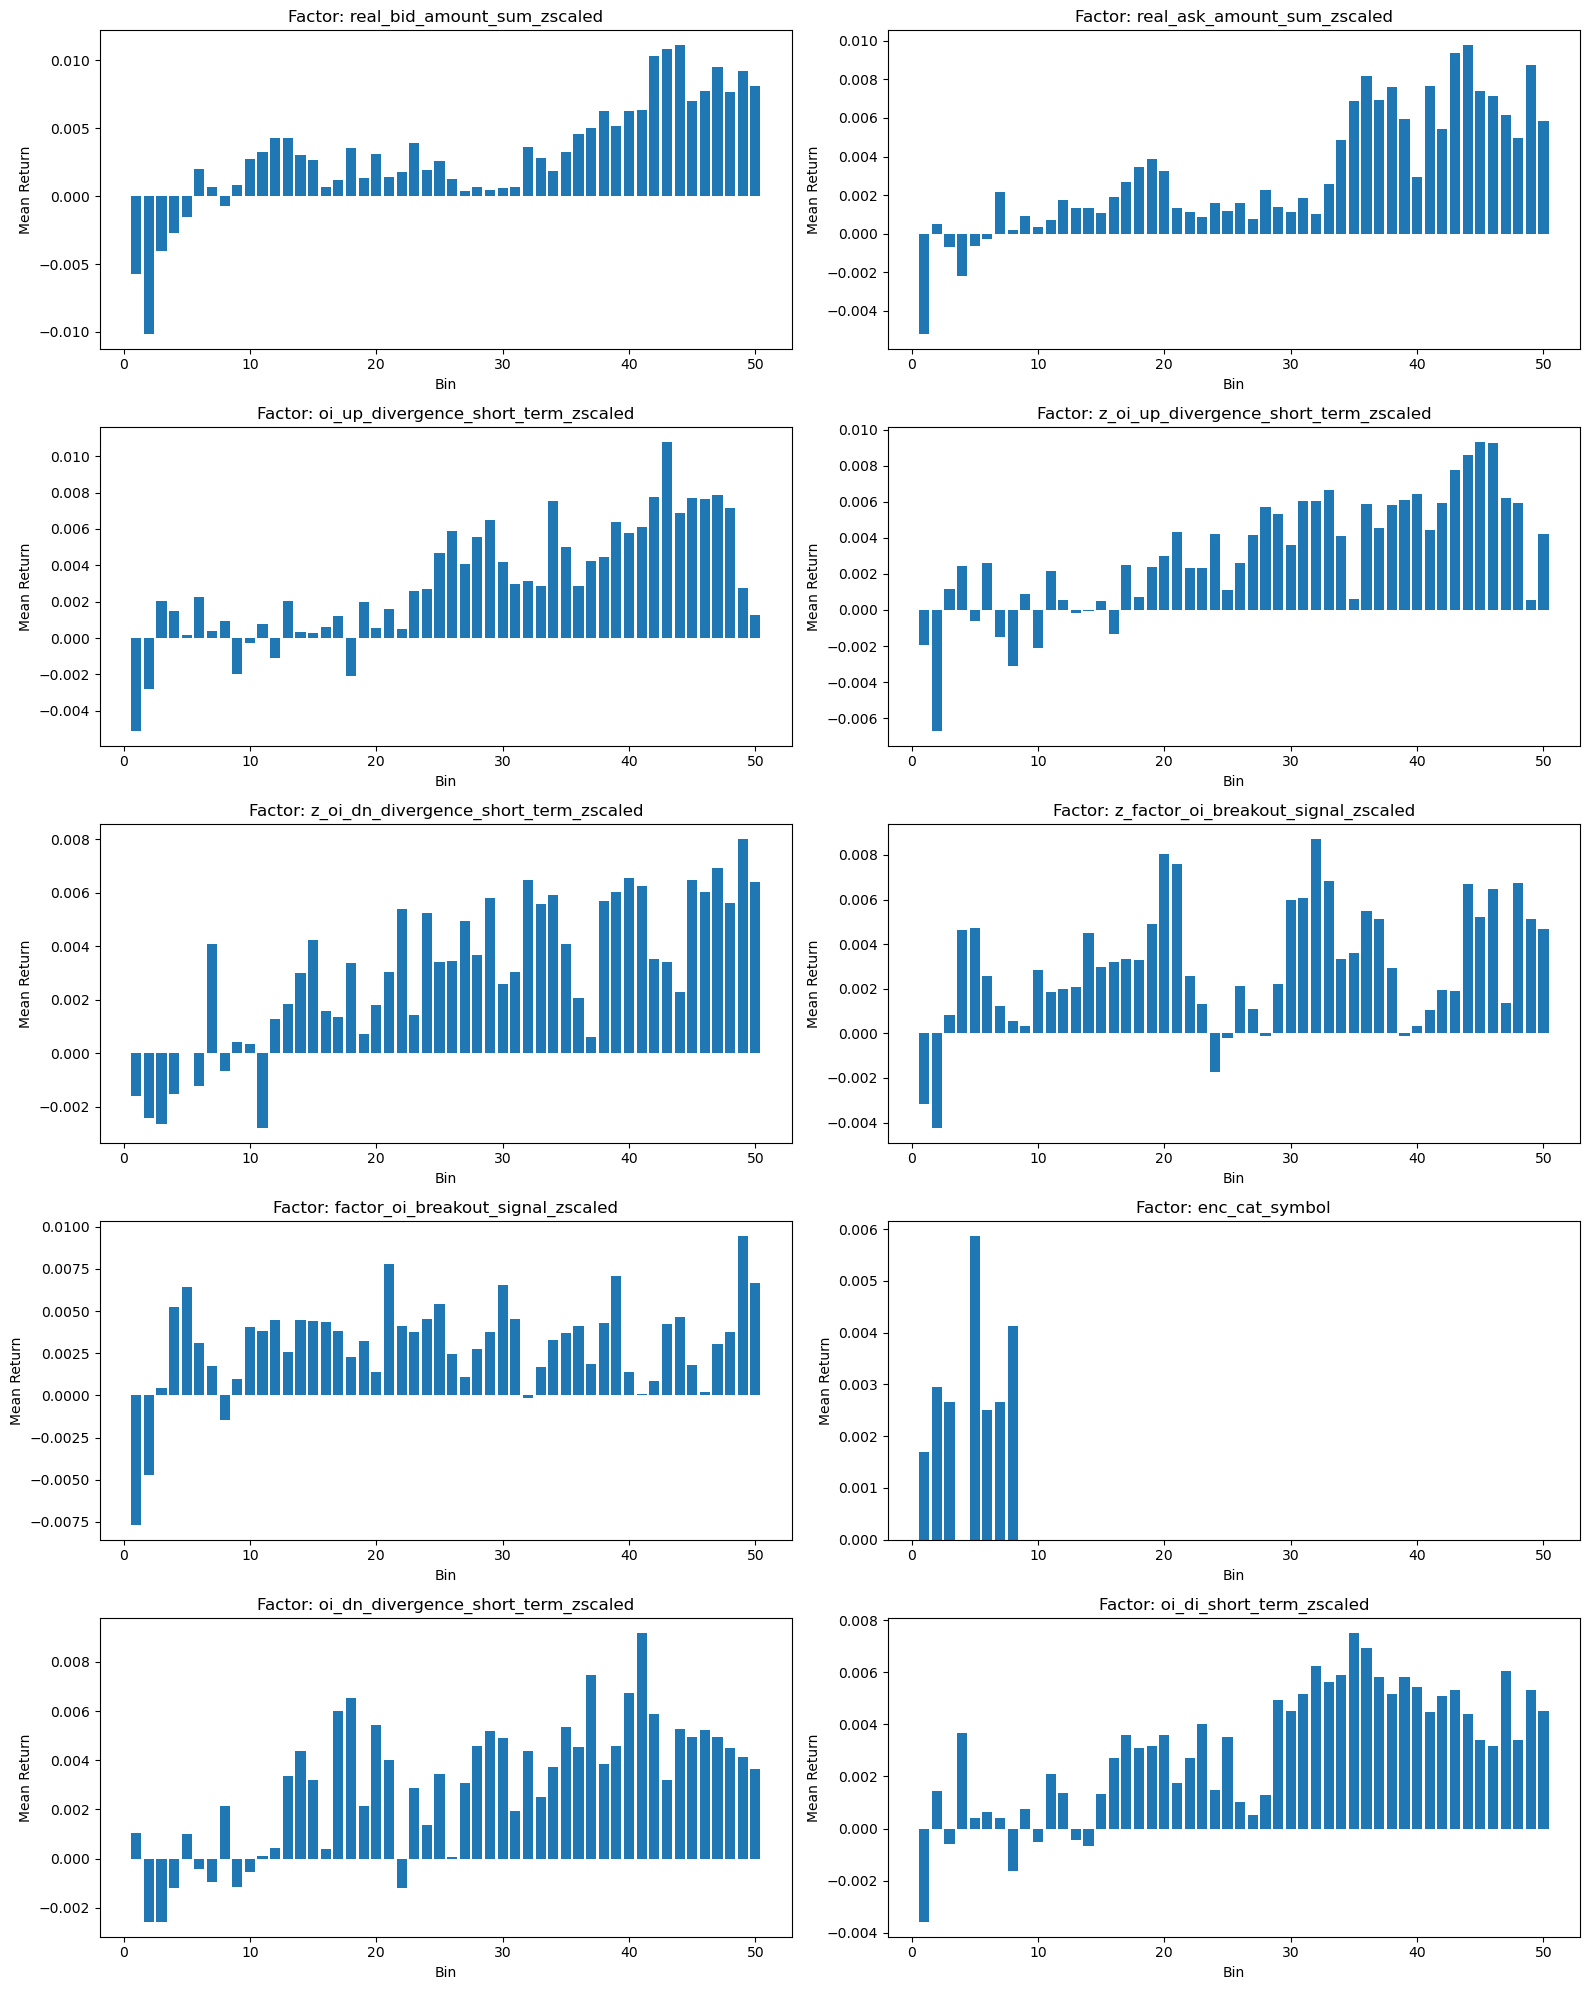

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i, factor in enumerate(top_factors):
    returns = bin_analysis(factor, weekly_dataframes, target_col, num_bins=50)
    axes[i].bar(range(1, 1 + len(returns)), returns)
    axes[i].set_title(f"Factor: {factor}")
    axes[i].set_xlabel("Bin")
    axes[i].set_ylabel("Mean Return")

plt.tight_layout()
plt.show()


In [23]:
print("总样本数：", len(full_df))


总样本数： 749040


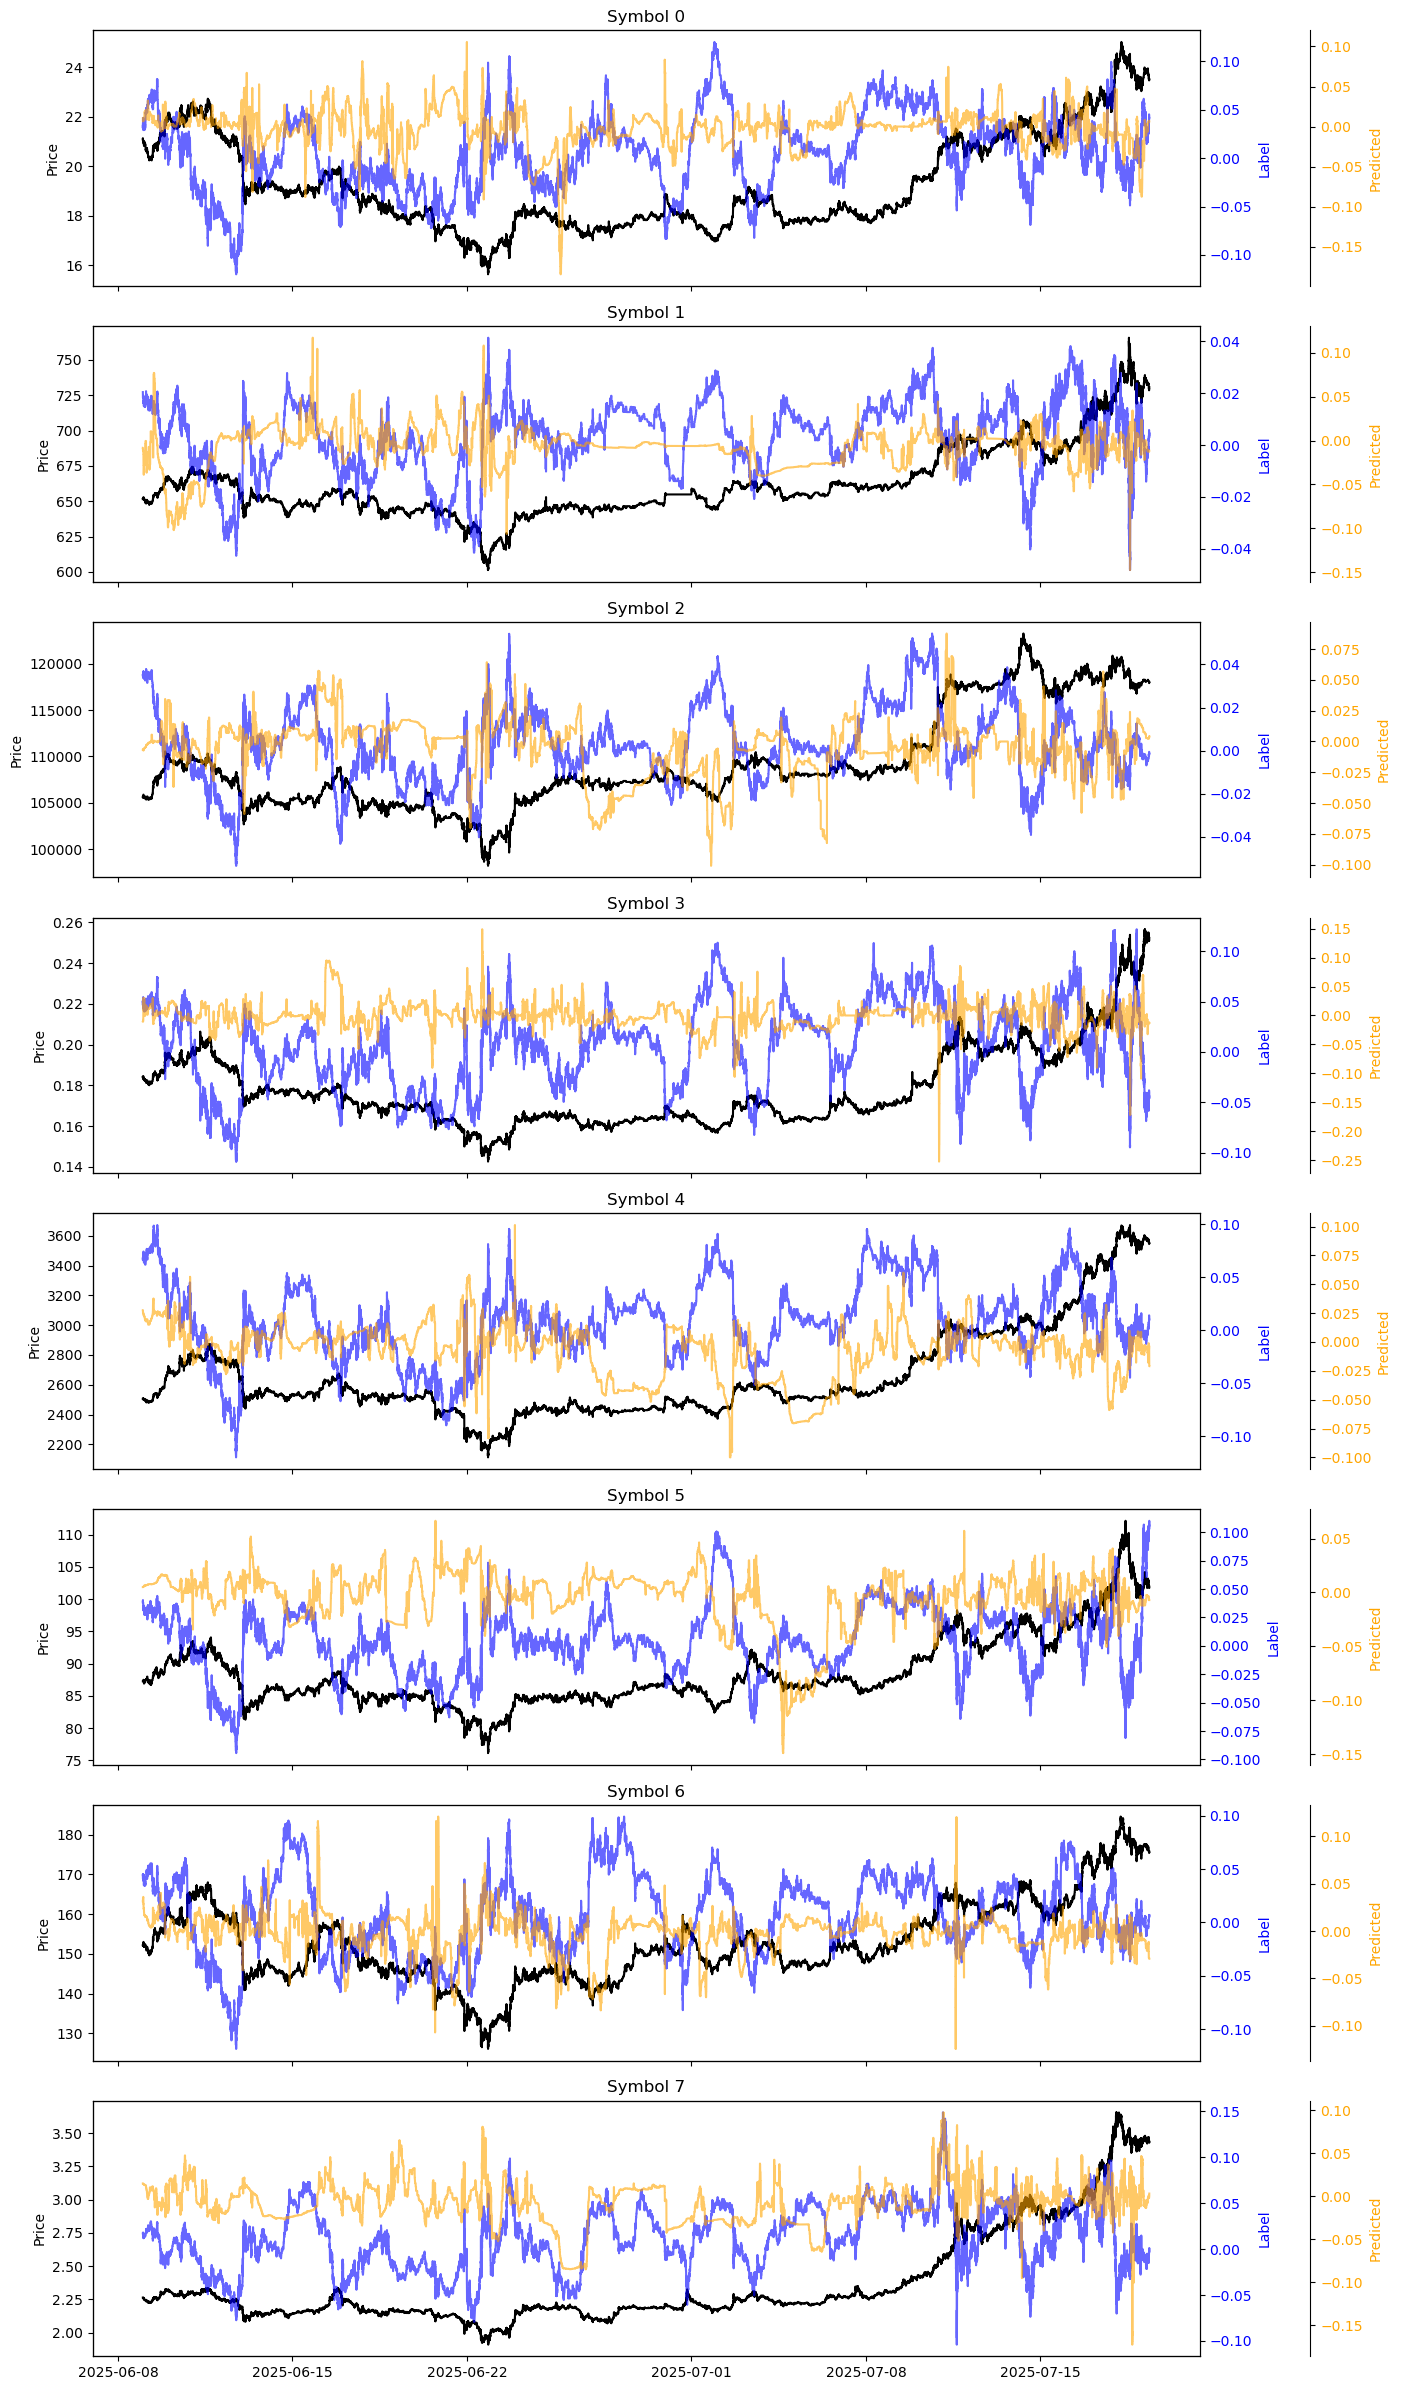

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你已有 df，包含 symbol_enc、timestamp、true_label、predicted_prob、px、position（自行添加）
# 转换 timestamp 为时间格式（如需要）
df = full_df
df["timestamp"] = pd.to_datetime(full_df["timestamp"], unit="ms")

# 遍历每个币种
symbols = df["symbol_enc"].unique()
fig, axs = plt.subplots(len(symbols), 1, figsize=(14, 3 * len(symbols)), sharex=True)

if len(symbols) == 1:
    axs = [axs]

for i, sym in enumerate(symbols):
    sym_df = df[df["symbol_enc"] == sym].copy()
    
    ax = axs[i]
    ax.set_title(f"Symbol {sym}")
    
    # 主轴: 价格
    ax.plot(sym_df["timestamp"], sym_df["px"], label="Price", color="black")
    ax.set_ylabel("Price", color="black")
    ax.tick_params(axis='y', labelcolor='black')

    # 第二轴: label
    ax2 = ax.twinx()
    ax2.plot(sym_df["timestamp"], sym_df["true_label"], label="Label", color="blue", alpha=0.6)
    ax2.set_ylabel("Label", color="blue")
    ax2.tick_params(axis='y', labelcolor='blue')

    # 第三轴: predicted prob
    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.1))  # 偏移右边
    ax3.plot(sym_df["timestamp"], sym_df["predicted_prob"], label="Pred Prob", color="orange", alpha=0.6)
    ax3.set_ylabel("Predicted", color="orange")
    ax3.tick_params(axis='y', labelcolor='orange')

    # 第四轴: position（如果你有这个字段）
    if "position" in sym_df.columns:
        ax4 = ax.twinx()
        ax4.spines.right.set_position(("axes", 1.2))  # 更偏移右边
        ax4.plot(sym_df["timestamp"], sym_df["position"], label="Position", color="green", alpha=0.6)
        ax4.set_ylabel("Position", color="green")
        ax4.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()


Calculating IC: 100%|█████████████████████████████████████████████████████████████████████████████████████| 93630/93630 [00:32<00:00, 2863.95it/s]


平均IC: 0.0535
平均IC std: 0.3806
信息比率 IR: 0.1407


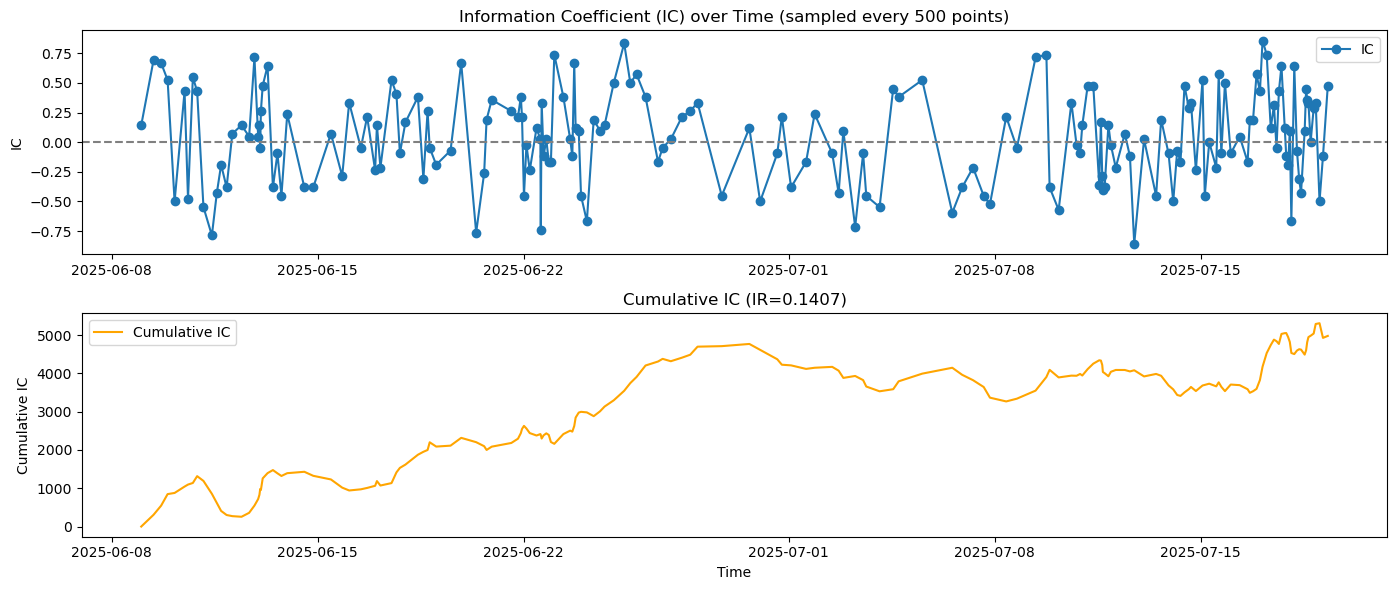

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

ic_list = []
time_list = []

# 计算每个时间截面的 IC
for ts, group in tqdm(full_df.groupby('timestamp'), total=full_df['timestamp'].nunique(), desc="Calculating IC"):
    if len(group) < 2:
        continue
    if group['predicted_prob'].nunique() < 2 or group['true_label'].nunique() < 2:
        continue
    ic, _ = spearmanr(group['predicted_prob'], group['true_label'])
    ic_list.append(ic)
    time_list.append(ts)

# 转为 np.array 和 datetime 格式（如需要）
ic_array = np.array(ic_list)
time_array = np.array(time_list)

# 排序时间（可选，保险做法）
sorted_idx = np.argsort(time_array)
time_array = time_array[sorted_idx]
ic_array = ic_array[sorted_idx]

# 计算累计 IC（cum IC）
cum_ic = np.cumsum(ic_array)

# 计算 IR（信息比率 = 平均IC / IC标准差）
ir = np.mean(ic_array) / np.std(ic_array)

# 打印信息
print(f"平均IC: {np.mean(ic_array):.4f}")
print(f"平均IC std: {np.std(ic_array):.4f}")

print(f"信息比率 IR: {ir:.4f}")

# 每隔500点采样一次
step = 500
time_array_sampled = time_array[::step]
ic_array_sampled = ic_array[::step]
cum_ic_sampled = cum_ic[::step]

# 绘图
plt.figure(figsize=(14, 6))

# 子图1: IC 时间序列图（采样后）
plt.subplot(2, 1, 1)
plt.plot(time_array_sampled, ic_array_sampled, marker='o', label='IC')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Information Coefficient (IC) over Time (sampled every 500 points)")
plt.ylabel("IC")
plt.legend()

# 子图2: 累积 IC 图（采样后）
plt.subplot(2, 1, 2)
plt.plot(time_array_sampled, cum_ic_sampled, color='orange', label='Cumulative IC')
plt.title(f"Cumulative IC (IR={ir:.4f})")
plt.xlabel("Time")
plt.ylabel("Cumulative IC")
plt.legend()

plt.tight_layout()
plt.show()


Calculating Period Returns: 100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 267.72it/s]



--- Strategy Performance Statistics ---
Cumulative Return        0.198281
Annualized Return        0.106435
Annualized Volatility    0.074334
Sharpe Ratio             1.431853
Max Drawdown            -0.060603
dtype: float64


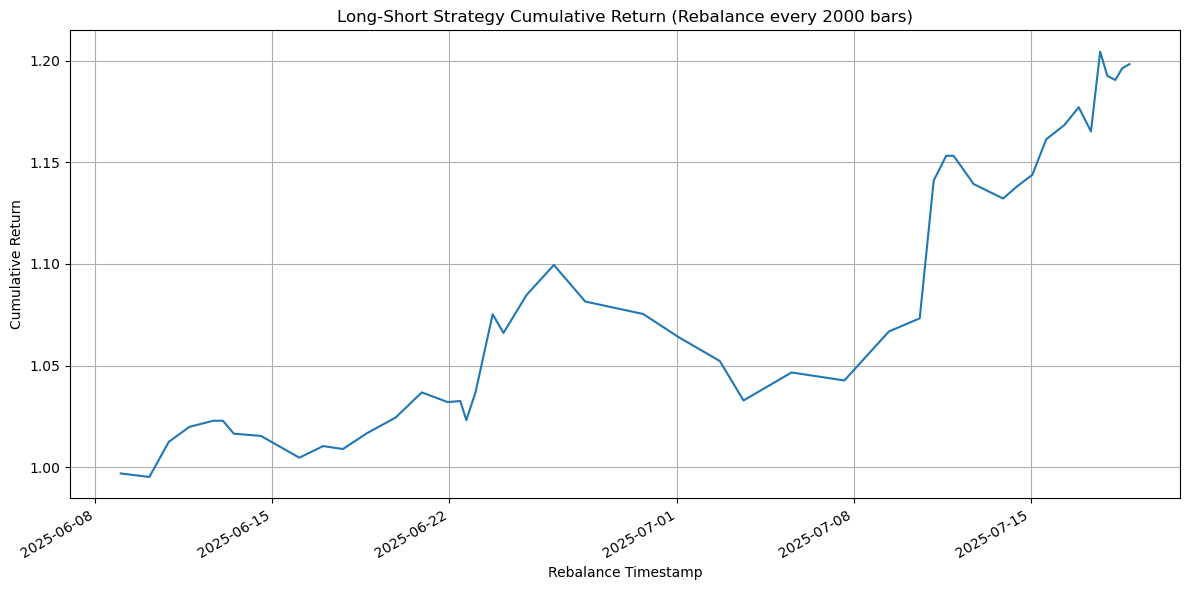

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 用于显示进度条

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp': 原始时间戳（例如毫秒），唯一且递增
# - 'symbol_enc': 币种编码
# - 'px': 当期价格
# - 'predicted_label': 模型预测的标签（分类或排名），越大表示越好

# --- 配置参数 ---
N_INTERVAL = N # 调仓周期，每 N_INTERVAL 个时间戳调仓一次

# N_INTERVAL = 1000 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次

# --- 数据预处理 ---
# 1. 转换时间戳为 datetime 类型，方便处理和绘图
bt_df = full_df
bt_df['dt'] = pd.to_datetime(full_df['timestamp'], unit='ms')

# 2. 确保数据按时间戳和币种排序，这是后续分组和shift操作的基础
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)

# 3. 获取所有唯一的、排序后的时间戳列表
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()

# 4. 确定所有调仓时间点
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）---
# 记录每个调仓时间点应持有的多空币种
rebalance_signals = {}
for t in tqdm(rebalance_times, desc="Identifying Rebalance Signals"):
    # 筛选出当前调仓时间点 t 的所有币种数据（截面数据）
    current_snapshot = bt_df[bt_df['dt'] == t]
    if current_snapshot.empty:
        continue

    # 找出 predicted_label 最高（最好）和最低（最差）的币种
    # 使用 .idxmax() 和 .idxmin() 找到索引，再用 .loc[] 提取 symbol_enc
    long_symbol = current_snapshot.loc[current_snapshot['predicted_prob'].idxmax(), 'symbol_enc']
    short_symbol = current_snapshot.loc[current_snapshot['predicted_prob'].idxmin(), 'symbol_enc']

    rebalance_signals[t] = {'long': long_symbol, 'short': short_symbol}

# --- 构建调仓周期内的持仓和计算周期收益 ---
# 存储每个调仓周期的策略收益
period_returns = []

# 初始化当前持仓，确保从第一个调仓点开始生效
current_long_symbol = None
current_short_symbol = None

# 遍历每个调仓周期
for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    # 确定当前调仓周期结束时间
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    # 从 rebalance_signals 获取当前周期的多空币种
    if start_time in rebalance_signals:
        current_long_symbol = rebalance_signals[start_time]['long']
        current_short_symbol = rebalance_signals[start_time]['short']
    else:
        # 如果当前调仓点没有信号（不应发生），则沿用上一个周期的头寸或保持空仓
        # 这里为了简化，假设如果有信号就会找到，没有则保持上一个有效头寸
        # 如果需要严格空仓，可以在这里设置 current_long_symbol = None, current_short_symbol = None
        pass

    # 如果没有有效头寸，跳过此周期（收益为0）
    if current_long_symbol is None or current_short_symbol is None:
        period_returns.append({'dt': start_time, 'strategy_log_return': 0.0})
        continue

    # 筛选出当前调仓周期内的所有数据
    # 包括起始时间点（进行调仓），但不包括结束时间点（结算）
    period_data = bt_df[(bt_df['dt'] >= start_time) & (bt_df['dt'] <= end_time)].copy()

    # 获取多头和空头币种在该周期开始和结束时的价格
    long_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == current_long_symbol)]['px'].iloc[0]
    long_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == current_long_symbol)]['px'].iloc[0]

    short_start_px = period_data[(period_data['dt'] == start_time) & (period_data['dt'] <= end_time) & (period_data['symbol_enc'] == current_short_symbol)]['px'].iloc[0]
    short_end_px = period_data[(period_data['dt'] == end_time) & (period_data['dt'] <= end_time) & (period_data['symbol_enc'] == current_short_symbol)]['px'].iloc[0]

    # 计算多头和空头在该周期内的对数收益率
    long_log_ret = np.log(long_end_px) - np.log(long_start_px)
    short_log_ret = np.log(short_end_px) - np.log(short_start_px)

    # 计算策略在该周期内的总对数收益（多头收益 + 空头收益的绝对值）
    # 假设各持仓权重相等，所以是 (多头收益 - 空头收益) / 2
    # 或者说，做多一个，做空一个，组合总收益
    strategy_period_log_return = (long_log_ret - short_log_ret) / 2 # 平均对冲策略

    period_returns.append({
        'dt': start_time,
        'strategy_log_return': strategy_period_log_return
    })

# 将周期收益转换为 DataFrame
strategy_returns_df = pd.DataFrame(period_returns).set_index('dt')
strategy_returns_series = strategy_returns_df['strategy_log_return']

# --- 绩效指标函数 ---
def perf_stats(return_series, periods_per_year):
    """
    计算并返回策略的绩效统计数据。
    return_series: 每个周期的对数收益率序列。
    periods_per_year: 一年内有多少个这样的周期（用于年化）。
    """
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp) # 对数收益累加后转回普通收益
    total_return = cum_ret.iloc[-1] - 1 # 累计普通收益

    # 年化收益率 (几何平均)
    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year) # 年化波动率
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    # 最大回撤 (基于普通收益)
    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 ---
# 假设每个时间戳是10分钟，N_INTERVAL=1000，则一个周期是 1000 * 10分钟 = 10000 分钟
# 一年大约有 52560 个10分钟的间隔 (365天 * 24小时 * 6个10分钟/小时)
# 则一年大约有 52560 / 1000 = 52.56 个 N_INTERVAL 周期
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) # 10分钟一档
# 或者更直接： (总时间戳数 / N_INTERVAL) / 总年数

stats = perf_stats(strategy_returns_series, periods_per_year_for_annualization)
print("\n--- Strategy Performance Statistics ---")
print(pd.Series(stats))

# --- 绘制累计收益曲线 ---
plt.figure(figsize=(12, 6))
# 对数收益累加，然后取指数，得到累计普通收益曲线
strategy_returns_series.cumsum().apply(np.exp).plot()
plt.title(f"Long-Short Strategy Cumulative Return (Rebalance every {N_INTERVAL} bars)")
plt.xlabel("Rebalance Timestamp")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

Calculating Period Returns: 100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 212.00it/s]



--- Strategy Performance Statistics ---
Cumulative Return        0.182824
Annualized Return        0.098432
Annualized Volatility    0.046714
Sharpe Ratio             2.107127
Max Drawdown            -0.022025
dtype: float64


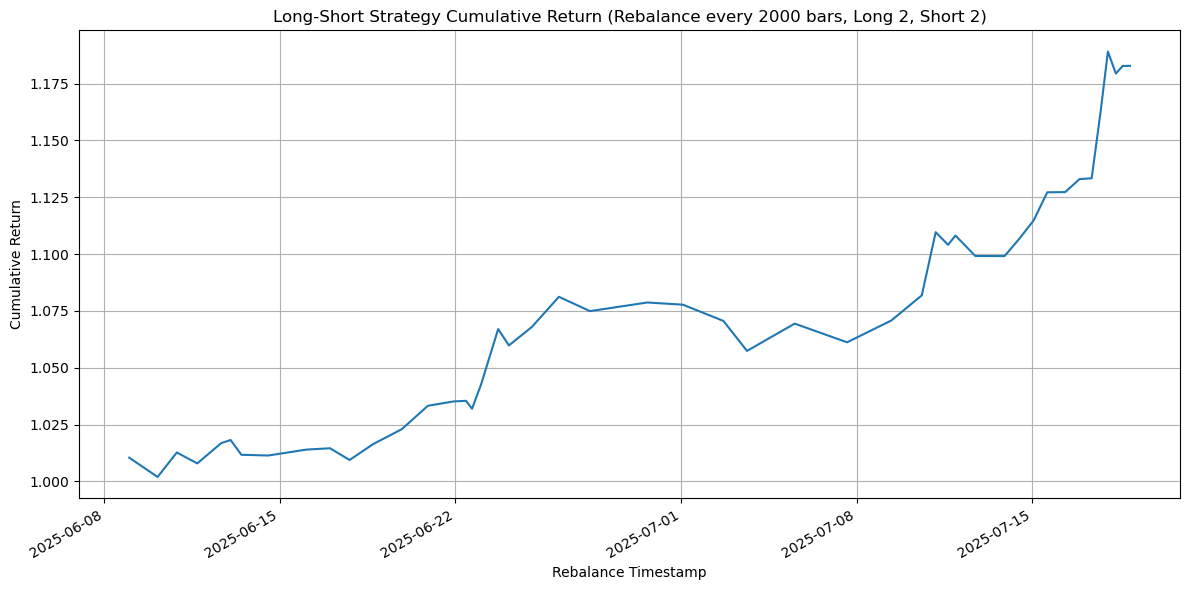

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp'（时间戳，可转为 datetime）
# - 'symbol_enc'（币种编码）
# - 'px'（当期价格）
# - 'predicted_label'（模型预测的 rank_label，0=最差、3=最好，或你自己定义的分类）

# --- 配置参数 ---
N_INTERVAL = N # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
# N_INTERVAL = 1000 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
N_LONG = 2         # 做多的品种数量（例如，前2个最好的）
N_SHORT = 2       # 做空的品种数量（例如，后2个最差的）

# --- 数据预处理 ---
# 1. 转换时间戳为 datetime 类型，方便处理和绘图
bt_df = full_df
bt_df['dt'] = pd.to_datetime(bt_df['timestamp'], unit='ms')

# 2. 确保数据按时间戳和币种排序，这是后续分组和shift操作的基础
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)

# 3. 获取所有唯一的、排序后的时间戳列表
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()

# 4. 确定所有调仓时间点
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）---
# 记录每个调仓时间点应持有的多空币种列表
rebalance_signals = {}
for t in tqdm(rebalance_times, desc="Identifying Rebalance Signals"):
    current_snapshot = bt_df[bt_df['dt'] == t].copy() # 使用.copy()避免SettingWithCopyWarning
    if current_snapshot.empty:
        continue

    # 根据 predicted_label 排序，选择前N_LONG和后N_SHORT个品种
    # 降序排列找到最好的，升序排列找到最差的
    sorted_by_prediction = current_snapshot.sort_values(by='predicted_prob', ascending=False)

    # 选择前 N_LONG 个最好的品种做多
    long_symbols = sorted_by_prediction.head(N_LONG)['symbol_enc'].tolist()
    
    # 选择后 N_SHORT 个最差的品种做空
    # 注意：如果 N_LONG + N_SHORT > 总品种数，需要避免重复
    # 确保做空品种与做多品种不重叠
    short_symbols_potential = sorted_by_prediction.tail(N_SHORT)['symbol_enc'].tolist()
    short_symbols = [s for s in short_symbols_potential if s not in long_symbols]

    rebalance_signals[t] = {'long': long_symbols, 'short': short_symbols}

# --- 构建调仓周期内的持仓和计算周期收益 ---
# 存储每个调仓周期的策略收益
period_returns = []

# 初始化当前持仓，确保从第一个调仓点开始生效
current_long_symbols = []
current_short_symbols = []

# 遍历每个调仓周期
for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    # 获取当前周期的多空币种列表
    if start_time in rebalance_signals:
        current_long_symbols = rebalance_signals[start_time]['long']
        current_short_symbols = rebalance_signals[start_time]['short']
    else:
        # 如果当前调仓点没有信号（不应发生），则沿用上一个周期的头寸或保持空仓
        pass # 维持前一周期头寸

    # 如果没有有效头寸（或数量不够），跳过此周期（收益为0）
    if not current_long_symbols or not current_short_symbols:
        period_returns.append({'dt': start_time, 'strategy_log_return': 0.0})
        continue

    # 筛选出当前调仓周期内的所有数据
    period_data = bt_df[(bt_df['dt'] >= start_time) & (bt_df['dt'] <= end_time)].copy()

    total_period_log_return = 0.0

    # 计算多头组合收益
    long_portfolio_log_return = 0.0
    for symbol in current_long_symbols:
        try:
            long_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
            long_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
            long_portfolio_log_return += (np.log(long_end_px) - np.log(long_start_px))
        except IndexError:
            # 币种数据缺失处理
            # print(f"Warning: Data for {symbol} missing at {start_time} or {end_time}")
            pass # 或者采取其他更严格的缺失处理方式

    # 计算空头组合收益
    short_portfolio_log_return = 0.0
    for symbol in current_short_symbols:
        try:
            short_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
            short_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
            short_portfolio_log_return += (np.log(short_end_px) - np.log(short_start_px))
        except IndexError:
            # 币种数据缺失处理
            # print(f"Warning: Data for {symbol} missing at {start_time} or {end_time}")
            pass # 或者采取其他更严格的缺失处理方式

    # 平均权重计算组合收益：(多头组合收益 - 空头组合收益) / 总持仓品种数
    # 假设每个选中的品种权重相等
    num_traded_symbols = len(current_long_symbols) + len(current_short_symbols)
    if num_traded_symbols > 0:
        total_period_log_return = (long_portfolio_log_return - short_portfolio_log_return) / num_traded_symbols
    else:
        total_period_log_return = 0.0 # 没有有效交易则收益为0

    period_returns.append({
        'dt': start_time,
        'strategy_log_return': total_period_log_return
    })

# 将周期收益转换为 DataFrame
strategy_returns_df = pd.DataFrame(period_returns).set_index('dt')
strategy_returns_series = strategy_returns_df['strategy_log_return']

# --- 绩效指标函数 (与之前相同，但强调基于周期性收益) ---
def perf_stats(return_series, periods_per_year):
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp)
    total_return = cum_ret.iloc[-1] - 1

    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 ---
# 假设每个时间戳是10分钟，N_INTERVAL=1000，则一个周期是 1000 * 10分钟 = 10000 分钟
# 则一年大约有 52560 / 1000 = 52.56 个 N_INTERVAL 周期
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) # 10分钟一档
# 请根据你的数据实际频率和 N_INTERVAL 重新计算此值！

stats = perf_stats(strategy_returns_series, periods_per_year_for_annualization)
print("\n--- Strategy Performance Statistics ---")
print(pd.Series(stats))

# --- 绘制累计收益曲线 ---
plt.figure(figsize=(12, 6))
strategy_returns_series.cumsum().apply(np.exp).plot()
plt.title(f"Long-Short Strategy Cumulative Return (Rebalance every {N_INTERVAL} bars, Long {N_LONG}, Short {N_SHORT})")
plt.xlabel("Rebalance Timestamp")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

Calculating Period Returns: 100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 138.28it/s]



--- Strategy Performance Statistics (Gross) ---
Cumulative Return        0.182824
Annualized Return        0.098432
Annualized Volatility    0.046714
Sharpe Ratio             2.107127
Max Drawdown            -0.022025
dtype: float64

--- Strategy Performance Statistics (Net of Costs) ---
Cumulative Return        0.103961
Annualized Return        0.056860
Annualized Volatility    0.047227
Sharpe Ratio             1.203980
Max Drawdown            -0.030302
dtype: float64

Total Transaction Cost (Sum of individual costs): 0.069000


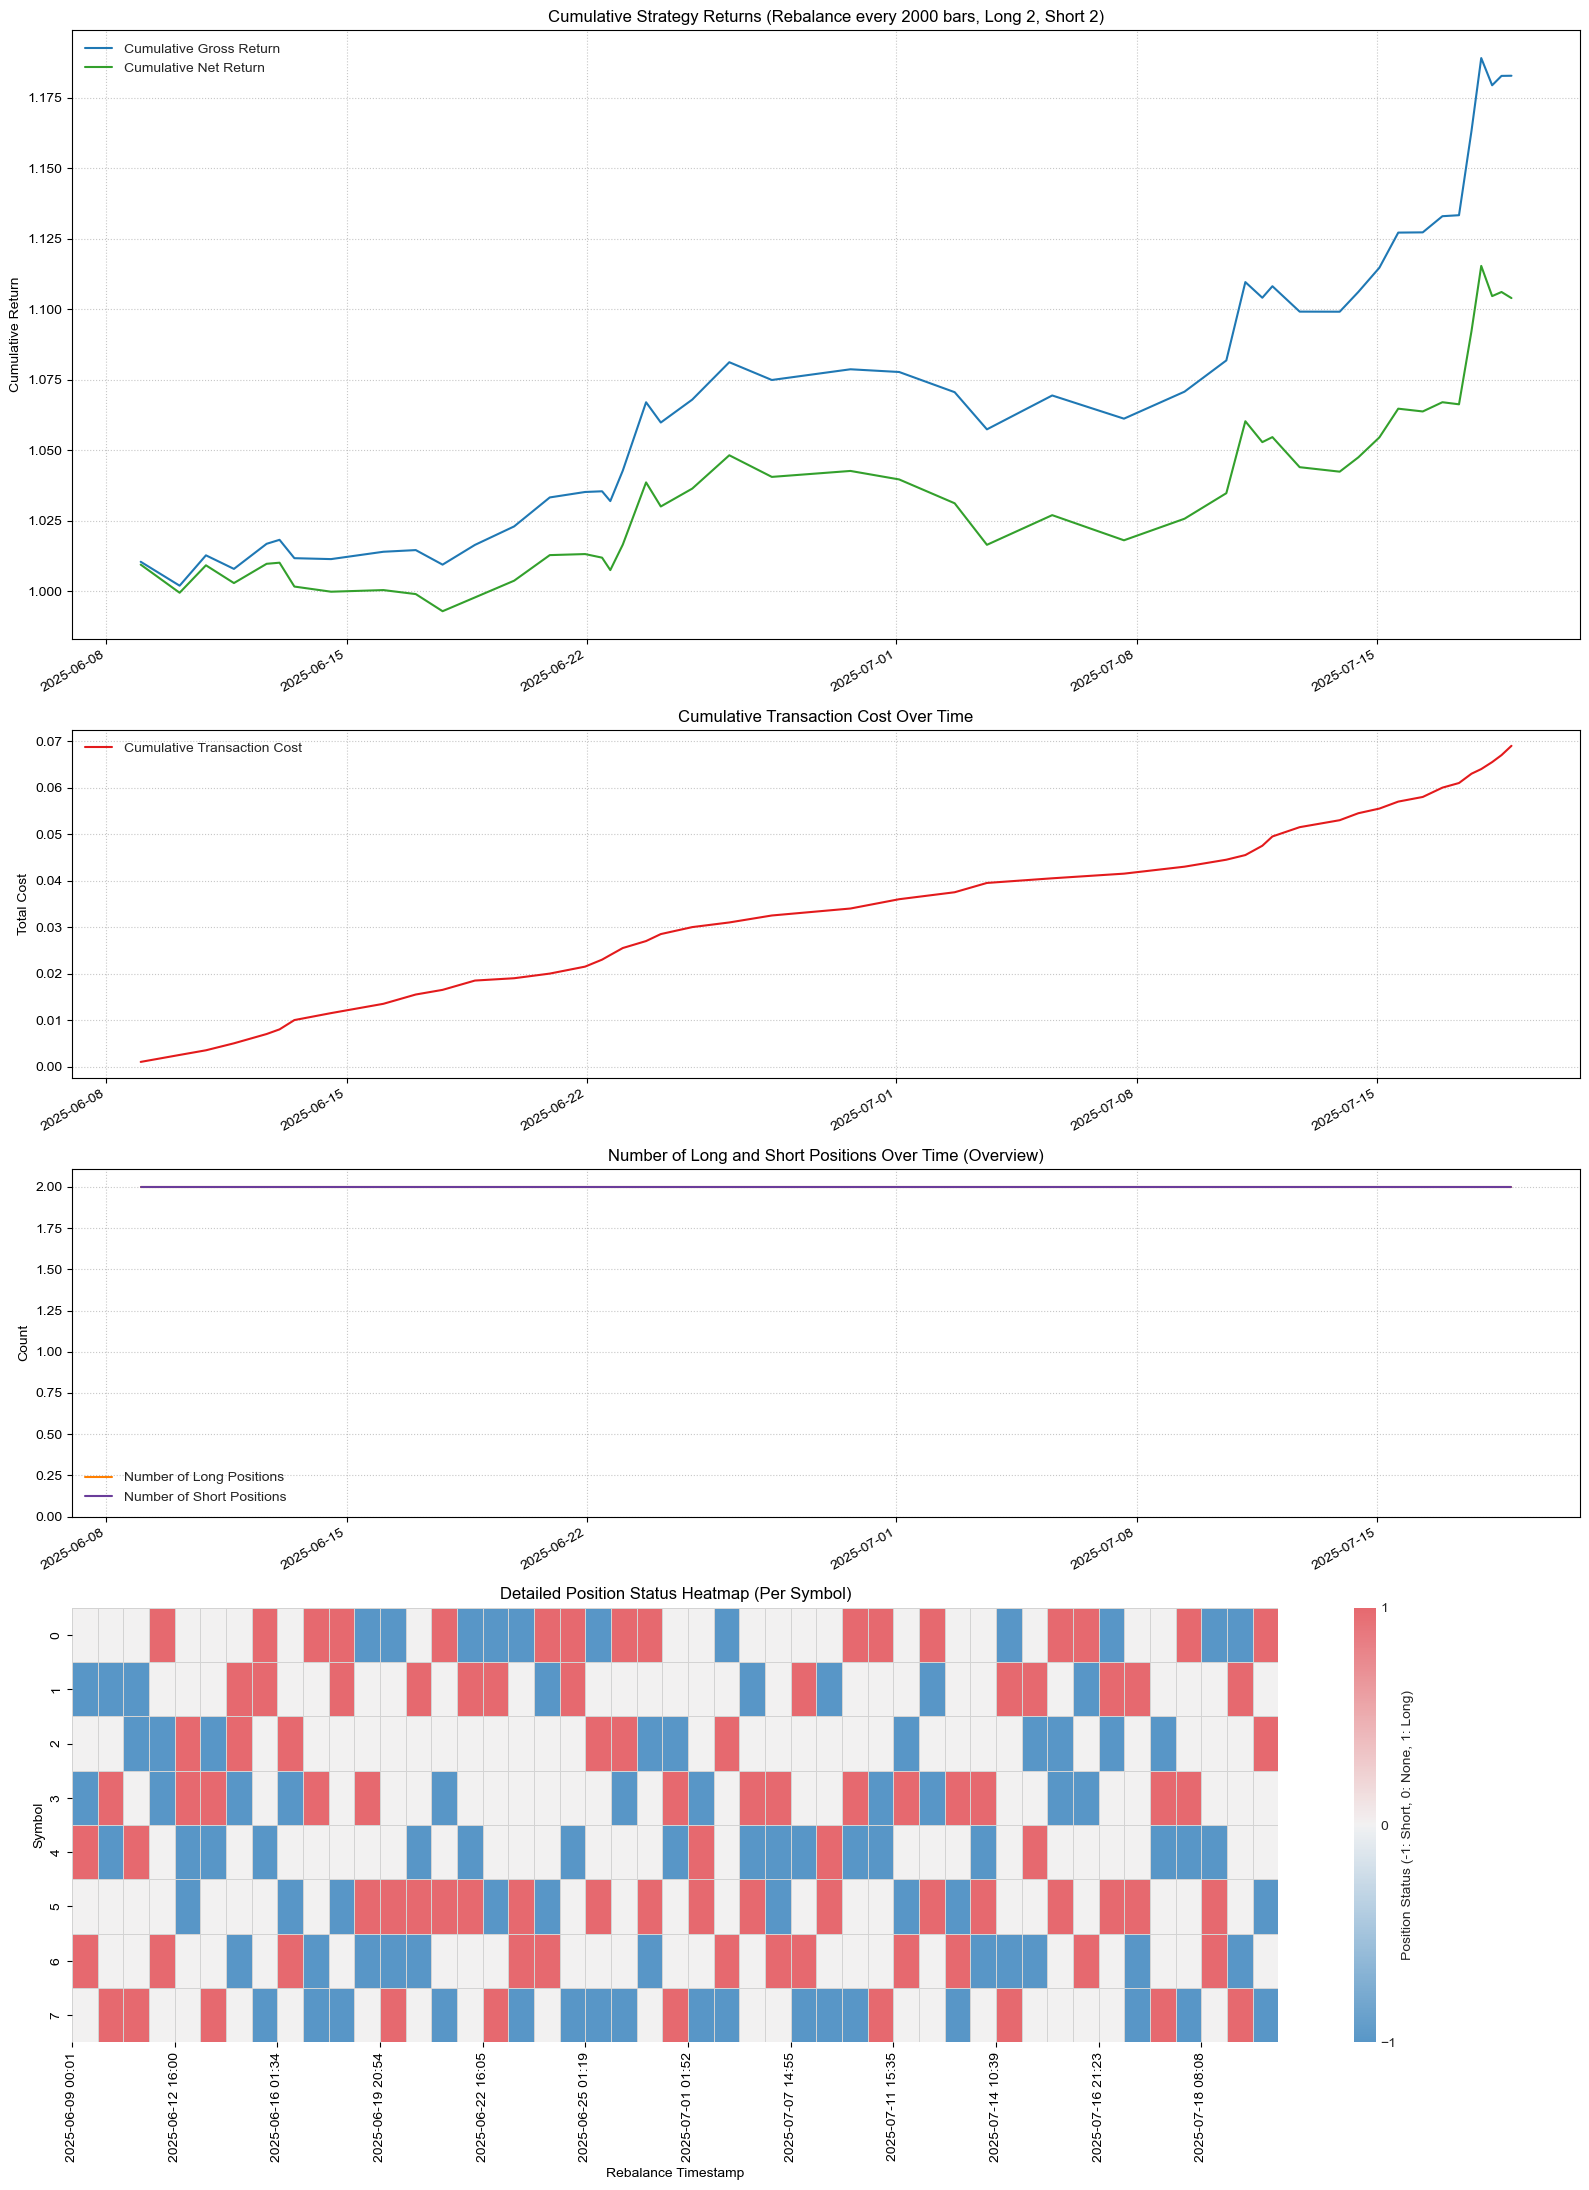

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns # 用于绘制热力图

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp'（时间戳，可转为 datetime）
# - 'symbol_enc'（币种编码）
# - 'px'（当期价格）
# - 'predicted_prob'（模型预测的概率，越大表示越好）

# --- 配置参数 ---
bt_df = full_df

N_INTERVAL = N * 1 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
N_LONG = 2    # 做多的品种数量
N_SHORT = 2      # 做空的品种数量
TRANSACTION_COST_PER_TRADE = 0.001 / (N_LONG + N_SHORT)


# --- 数据预处理 (与之前相同) ---
bt_df['dt'] = pd.to_datetime(bt_df['timestamp'], unit='ms')
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）(与之前相同) ---
rebalance_signals = {}
for t in tqdm(rebalance_times, desc="Identifying Rebalance Signals"):
    current_snapshot = bt_df[bt_df['dt'] == t].copy()
    if current_snapshot.empty:
        continue

    sorted_by_prediction = current_snapshot.sort_values(by='predicted_prob', ascending=False)
    long_symbols = sorted_by_prediction.head(N_LONG)['symbol_enc'].tolist()
    short_symbols_potential = sorted_by_prediction.tail(N_SHORT)['symbol_enc'].tolist()
    short_symbols = [s for s in short_symbols_potential if s not in long_symbols]

    rebalance_signals[t] = {'long': long_symbols, 'short': short_symbols}

# --- 构建调仓周期内的持仓和计算周期收益 (与之前相同) ---
period_results = []
all_positions_by_period = []

current_long_symbols = []
current_short_symbols = []

for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    prev_long_symbols = current_long_symbols[:]
    prev_short_symbols = current_short_symbols[:]

    if start_time in rebalance_signals:
        current_long_symbols = rebalance_signals[start_time]['long']
        current_short_symbols = rebalance_signals[start_time]['short']
    
    # --- 记录当前调仓周期所有品种的持仓状态 ---
    all_unique_symbols = bt_df['symbol_enc'].unique()
    current_period_positions = {symbol: 0 for symbol in all_unique_symbols}

    for symbol in current_long_symbols:
        current_period_positions[symbol] = 1

    for symbol in current_short_symbols:
        if current_period_positions[symbol] != 1:
            current_period_positions[symbol] = -1

    all_positions_by_period.append({'dt': start_time, **current_period_positions})

    # --- 计算本周期的策略收益 (毛收益) ---
    gross_period_log_return = 0.0
    if not current_long_symbols or not current_short_symbols:
        gross_period_log_return = 0.0
    else:
        period_data = bt_df[(bt_df['dt'] >= start_time) & (bt_df['dt'] <= end_time)].copy()

        long_portfolio_log_return = 0.0
        for symbol in current_long_symbols:
            try:
                long_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                long_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                long_portfolio_log_return += (np.log(long_end_px) - np.log(long_start_px))
            except IndexError:
                long_portfolio_log_return += 0.0
                pass

        short_portfolio_log_return = 0.0
        for symbol in current_short_symbols:
            try:
                short_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                short_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                short_portfolio_log_return += (np.log(short_end_px) - np.log(short_start_px))
            except IndexError:
                short_portfolio_log_return += 0.0
                pass

        num_traded_symbols = len(current_long_symbols) + len(current_short_symbols)
        if num_traded_symbols > 0:
            gross_period_log_return = (long_portfolio_log_return - short_portfolio_log_return) / num_traded_symbols
        else:
            gross_period_log_return = 0.0

    # --- 计算本周期的交易手续费 ---
    transaction_cost_this_period = 0.0
    if i > 0:
        close_long_count = len([s for s in prev_long_symbols if s not in current_long_symbols])
        close_short_count = len([s for s in prev_short_symbols if s not in current_short_symbols])
        
        open_long_count = len([s for s in current_long_symbols if s not in prev_long_symbols])
        open_short_count = len([s for s in current_short_symbols if s not in prev_short_symbols])
        
        transaction_cost_this_period = (close_long_count + close_short_count + open_long_count + open_short_count) * TRANSACTION_COST_PER_TRADE
    else:
        transaction_cost_this_period = (len(current_long_symbols) + len(current_short_symbols)) * TRANSACTION_COST_PER_TRADE

    net_period_log_return = gross_period_log_return - transaction_cost_this_period 
    
    period_results.append({
        'dt': start_time,
        'gross_strategy_log_return': gross_period_log_return,
        'transaction_cost': transaction_cost_this_period,
        'net_strategy_log_return': net_period_log_return,
        'num_long_positions': len(current_long_symbols),
        'num_short_positions': len(current_short_symbols),
        'long_symbols_list': current_long_symbols,
        'short_symbols_list': current_short_symbols
    })

# 将周期结果转换为 DataFrame
strategy_results_df = pd.DataFrame(period_results).set_index('dt')

# --- 准备持仓热力图数据 ---
positions_heatmap_df = pd.DataFrame(all_positions_by_period).set_index('dt')
positions_heatmap_df = positions_heatmap_df[sorted(positions_heatmap_df.columns)]


# --- 绩效指标函数 (与之前相同) ---
def perf_stats(return_series, periods_per_year):
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp)
    total_return = cum_ret.iloc[-1] - 1

    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 (与之前相同) ---
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) 

print("\n--- Strategy Performance Statistics (Gross) ---")
gross_stats = perf_stats(strategy_results_df['gross_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(gross_stats))

print("\n--- Strategy Performance Statistics (Net of Costs) ---")
net_stats = perf_stats(strategy_results_df['net_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(net_stats))

print(f"\nTotal Transaction Cost (Sum of individual costs): {strategy_results_df['transaction_cost'].sum():.6f}")

# --- 绘制图表 (使用低饱和度配色) ---
fig, axes = plt.subplots(4, 1, figsize=(16, 22), sharex=False, gridspec_kw={'height_ratios': [0.35, 0.2, 0.2, 0.25]})

# 定义低饱和度颜色
# 可以选择 seaborn 的 palette，或者自定义 HEX 颜色
# muted, pastel, dark, bright, deep, colorblind
# 例如：sns.color_palette("muted") 或 sns.color_palette("viridis", as_cmap=True)

# 曲线图颜色
COLOR_GROSS_RETURN = sns.color_palette("Paired")[1] # 柔和的蓝色
COLOR_NET_RETURN = sns.color_palette("Paired")[3]   # 柔和的绿色
COLOR_TRANSACTION_COST = sns.color_palette("Paired")[5] # 柔和的红色
COLOR_LONG_POSITIONS = sns.color_palette("Paired")[7] # 柔和的紫色
COLOR_SHORT_POSITIONS = sns.color_palette("Paired")[9] # 柔和的橙色

# 热力图颜色映射 (低饱和度 RdBu)
HEATMAP_CMAP = sns.diverging_palette(240, 10, as_cmap=True, s=70, l=60, sep=1) # 240 (蓝) 到 10 (红), 饱和度70, 亮度60, 分离度1
# 其他可选的低饱和度发散型色图： 'coolwarm_r', 'Spectral_r', 'vlag', 'icefire'
# 或者自定义一个更温和的 RdBu
# HEATMAP_CMAP = plt.cm.get_cmap('RdBu', 3) # RdBu色图取3个离散值，可能需要进一步调低饱和度
# HEATMAP_CMAP = LinearSegmentedColormap.from_list("mycmap", [(0, "darkred"), (0.5, "lightgray"), (1, "darkblue")]) # 更精细自定义

# 设置图表背景风格 (可选，例如设置为白色背景)
plt.style.use('seaborn-v0_8-whitegrid') # 或者 'seaborn-v0_8-pastel' / 'seaborn-v0_8-muted'


# 子图1: 累计收益 (毛收益 vs. 净收益)
strategy_results_df['gross_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Gross Return', color=COLOR_GROSS_RETURN)
strategy_results_df['net_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Net Return', color=COLOR_NET_RETURN)
axes[0].set_title(f"Cumulative Strategy Returns (Rebalance every {N_INTERVAL} bars, Long {N_LONG}, Short {N_SHORT})")
axes[0].set_ylabel("Cumulative Return")
axes[0].legend()
axes[0].grid(True, linestyle=':', alpha=0.7) # 调整网格线样式和透明度
axes[0].set_xlabel("")

# 子图2: 累计手续费消耗
strategy_results_df['transaction_cost'].cumsum().plot(ax=axes[1], label='Cumulative Transaction Cost', color=COLOR_TRANSACTION_COST)
axes[1].set_title("Cumulative Transaction Cost Over Time")
axes[1].set_ylabel("Total Cost")
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.7)
axes[1].set_xlabel("")

# 子图3: 持仓数量变化 (保留，作为快速概览)
strategy_results_df['num_long_positions'].plot(ax=axes[2], label='Number of Long Positions', color=COLOR_LONG_POSITIONS, drawstyle='steps-post')
strategy_results_df['num_short_positions'].plot(ax=axes[2], label='Number of Short Positions', color=COLOR_SHORT_POSITIONS, drawstyle='steps-post')
axes[2].set_title("Number of Long and Short Positions Over Time (Overview)")
axes[2].set_ylabel("Count")
axes[2].set_xlabel("")
axes[2].legend()
axes[2].grid(True, linestyle=':', alpha=0.7)
axes[2].set_ylim(bottom=0)

# 子图4: 详细持仓热力图
if not positions_heatmap_df.empty:
    sns.heatmap(
        positions_heatmap_df.T,
        cmap=HEATMAP_CMAP, # 使用新的低饱和度色图
        cbar_kws={'ticks': [-1, 0, 1], 'label': 'Position Status (-1: Short, 0: None, 1: Long)'},
        ax=axes[3],
        yticklabels=True,
        xticklabels=True,
        linewidths=0.5, # 增加网格线
        linecolor='lightgray' # 网格线颜色
    )
    axes[3].set_title("Detailed Position Status Heatmap (Per Symbol)")
    axes[3].set_xlabel("Rebalance Timestamp")
    axes[3].set_ylabel("Symbol")
    
    # 调整x轴刻度标签，避免重叠
    num_ticks = 10 
    if len(positions_heatmap_df.index) > num_ticks:
        tick_interval = len(positions_heatmap_df.index) // num_ticks
        axes[3].set_xticks(np.arange(0, len(positions_heatmap_df.index), tick_interval))
        axes[3].set_xticklabels(positions_heatmap_df.index[::tick_interval].strftime('%Y-%m-%d %H:%M'))
    else:
        axes[3].set_xticklabels(positions_heatmap_df.index.strftime('%Y-%m-%d %H:%M'))

plt.tight_layout()
plt.show()

Calculating Period Returns:  94%|███████████████████████████████████████████████████████████████████████████▊     | 44/47 [00:00<00:00, 77.59it/s]

  -> Linkage: Closed weakest LONG 3 to rebalance.


Calculating Period Returns: 100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 78.48it/s]



--- Strategy Performance Statistics (Gross) ---
Cumulative Return        0.064260
Annualized Return        0.035437
Annualized Volatility    0.028501
Sharpe Ratio             1.243379
Max Drawdown            -0.033155
dtype: float64

--- Strategy Performance Statistics (Net of Costs) ---
Cumulative Return        0.014636
Annualized Return        0.008157
Annualized Volatility    0.028182
Sharpe Ratio             0.289452
Max Drawdown            -0.040379
dtype: float64

Total Transaction Cost (Sum of individual costs): 0.047750


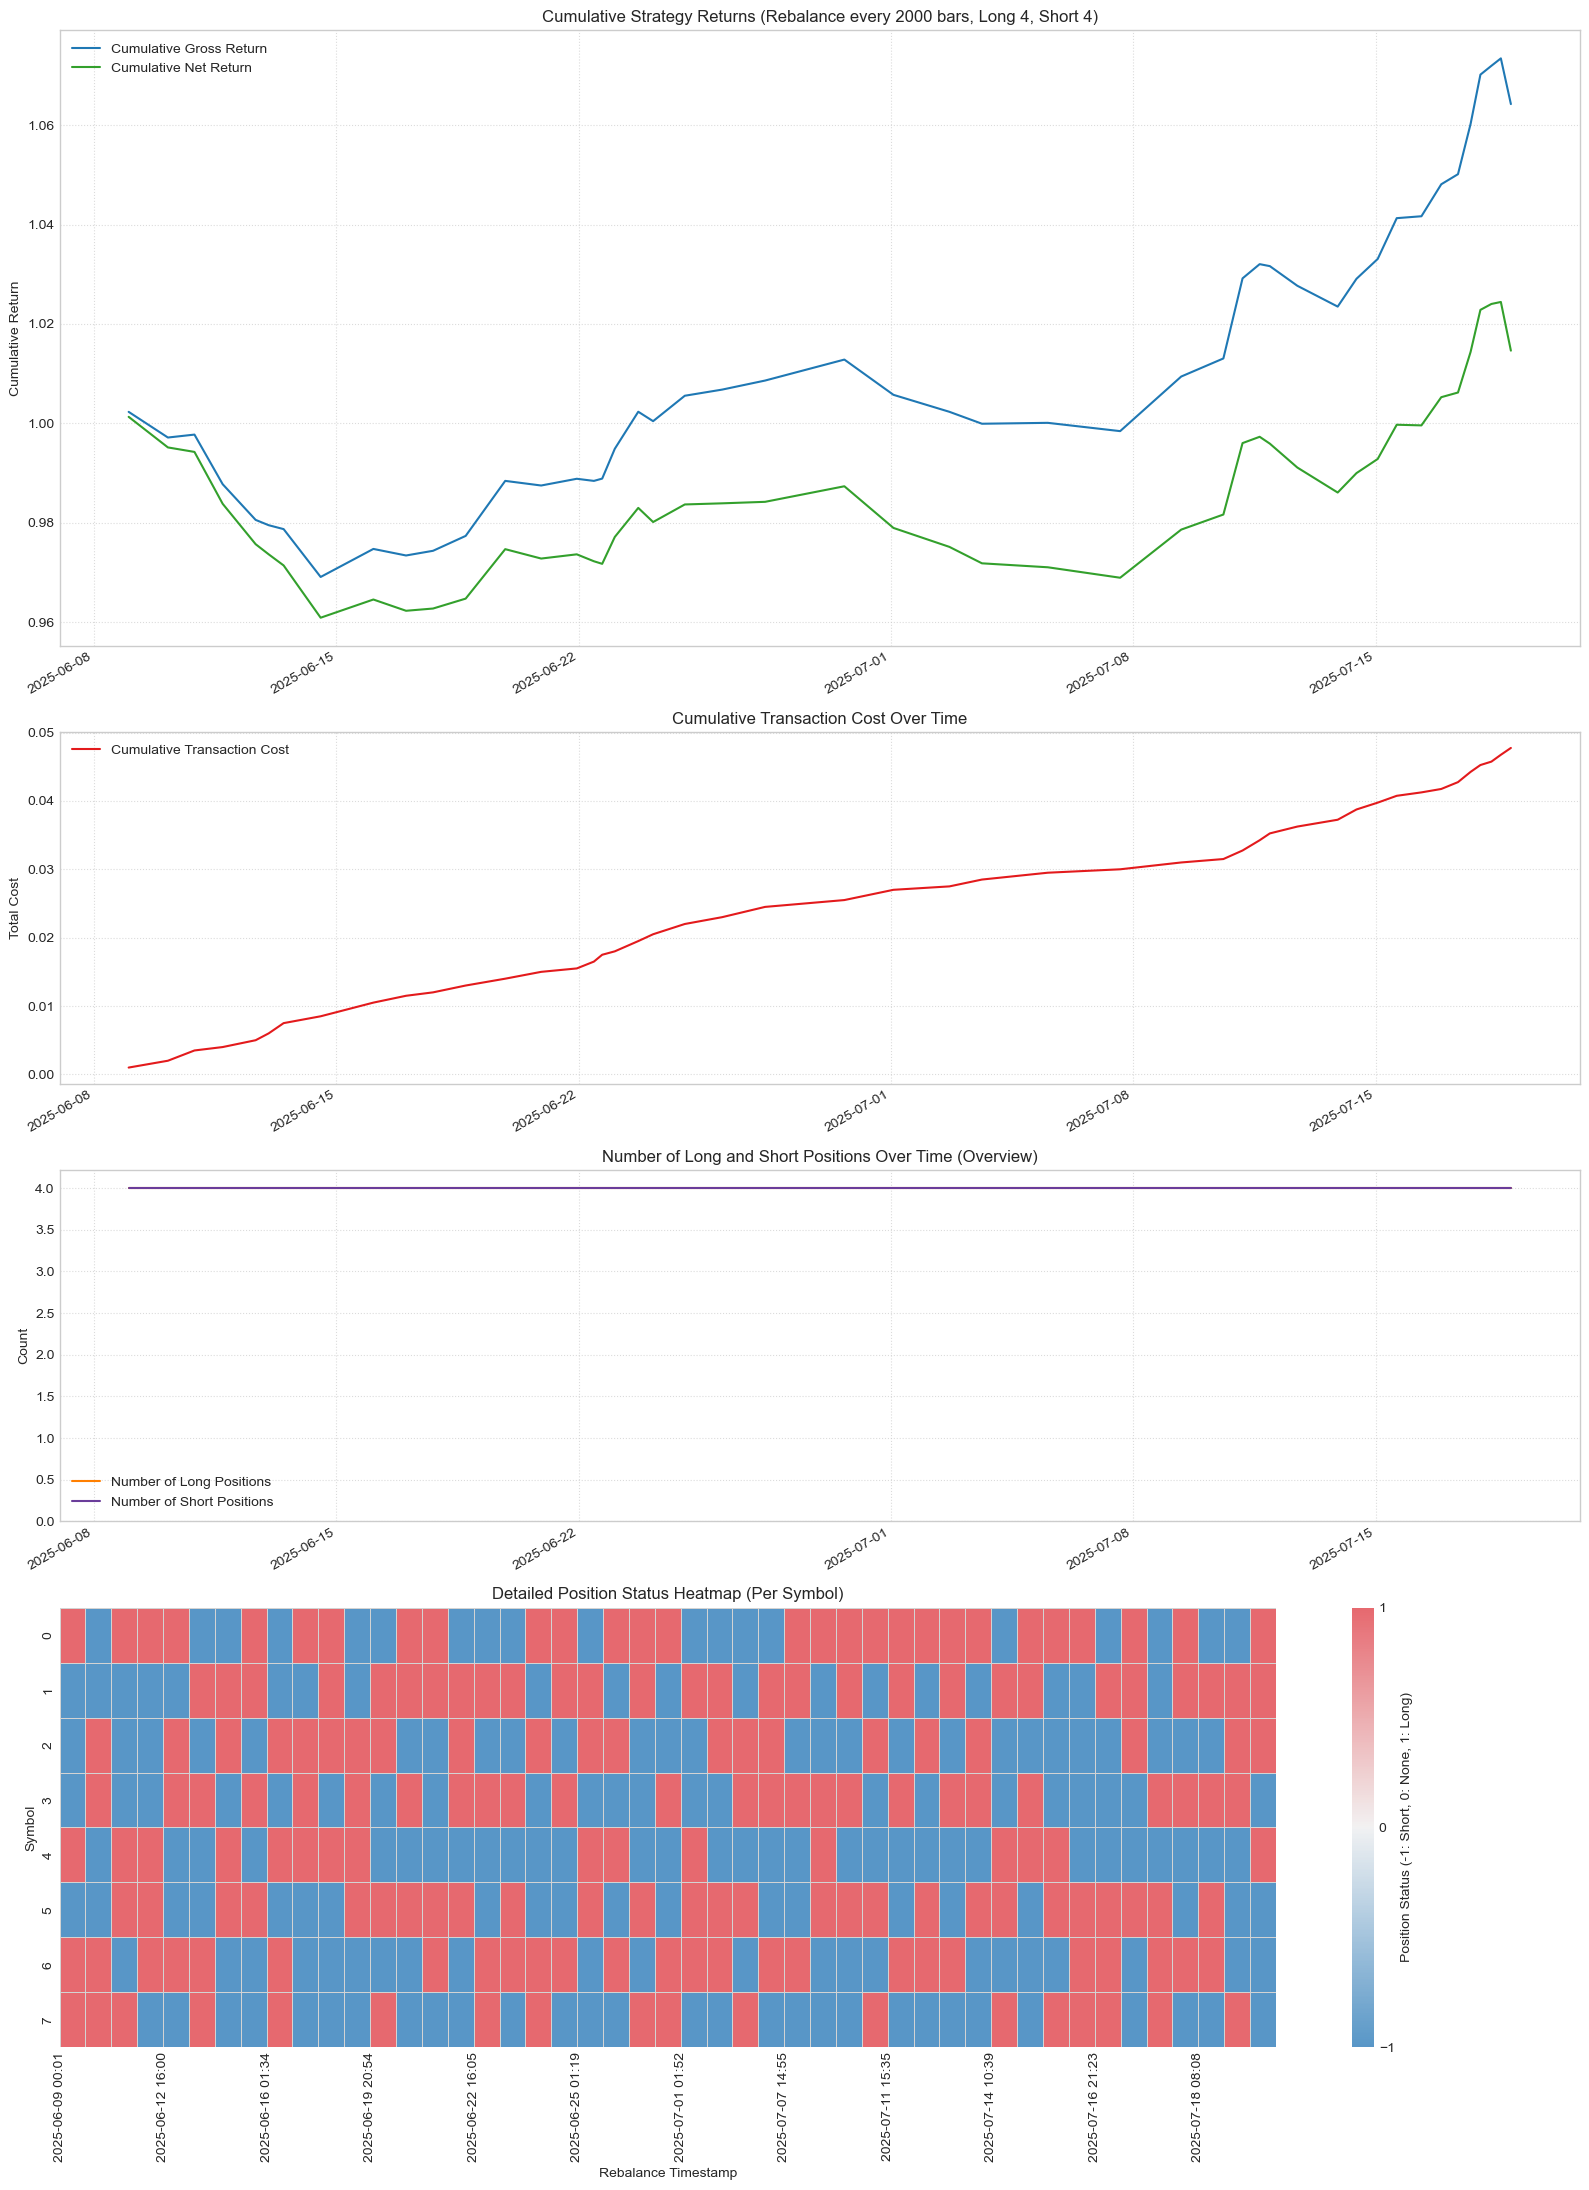

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns # 用于绘制热力图

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp'（时间戳，可转为 datetime）
# - 'symbol_enc'（币种编码）
# - 'px'（当期价格）
# - 'predicted_prob'（模型预测的概率，越大表示越好）

# --- 配置参数 ---
# 注意：你的原始代码中 bt_df = full_df，这里假设 full_df 已经被传入或定义
# 如果 full_df 是一个未定义的变量，你需要在这里定义或加载它
# 例如：bt_df = pd.read_csv('your_data.csv')
# 或者 bt_df = full_df # 如果 full_df 在此脚本外部定义

# 这里N是一个未定义的变量，你需要给它一个具体的值，例如 100
bt_df = full_df 


N_INTERVAL = N * 1 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
# N_INTERVAL = 2000
N_LONG = 4       # 做多的品种数量
N_SHORT = 4        # 做空的品种数量
TRANSACTION_COST_PER_TRADE = 0.001 / (N_LONG + N_SHORT)

# 新增：单币种止损参数
STOP_LOSS_PERCENT = 0.15 # 单币种止损百分比，例如 0.05 表示 5% 的亏损止损

# --- 数据预处理 ---
bt_df['dt'] = pd.to_datetime(bt_df['timestamp'], unit='ms')
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）---
rebalance_signals = {}
for t in tqdm(rebalance_times, desc="Identifying Rebalance Signals"):
    current_snapshot = bt_df[bt_df['dt'] == t].copy()
    if current_snapshot.empty:
        rebalance_signals[t] = {'long': [], 'short': [], 'prices': {}} # 增加prices字典
        continue

    # 根据预测值排序
    sorted_by_prediction = current_snapshot.sort_values(by='predicted_prob', ascending=False)
    
    # 选择多头和空头品种
    long_symbols = sorted_by_prediction.head(N_LONG)['symbol_enc'].tolist()
    short_symbols_potential = sorted_by_prediction.tail(N_SHORT)['symbol_enc'].tolist()
    
    # 确保做空品种不与做多品种重复
    short_symbols = [s for s in short_symbols_potential if s not in long_symbols]

    # !!! 强制多空同时开仓 !!!
    if not long_symbols or not short_symbols:
        rebalance_signals[t] = {'long': [], 'short': [], 'prices': {}}
    else:
        # 记录开仓时的价格
        prices = {}
        for symbol in long_symbols:
            px = current_snapshot[current_snapshot['symbol_enc'] == symbol]['px'].iloc[0]
            prices[symbol] = px
        for symbol in short_symbols:
            px = current_snapshot[current_snapshot['symbol_enc'] == symbol]['px'].iloc[0]
            prices[symbol] = px

        rebalance_signals[t] = {'long': long_symbols, 'short': short_symbols, 'prices': prices}

# --- 构建调仓周期内的持仓和计算周期收益 ---
period_results = []
all_positions_by_period = []

current_long_positions = {}  # {symbol: open_price}
current_short_positions = {} # {symbol: open_price}

for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    # 获取当前周期的数据快照
    period_data = bt_df[(bt_df['dt'] >= start_time) & (bt_df['dt'] <= end_time)].copy()
    if period_data.empty:
        # 如果当前时间段没有数据，则跳过
        continue

    # 获取当前时间点（周期开始）的价格快照，用于调仓决策
    current_moment_prices = bt_df[bt_df['dt'] == start_time].set_index('symbol_enc')['px'].to_dict()
    current_moment_preds = bt_df[bt_df['dt'] == start_time].set_index('symbol_enc')['predicted_prob'].to_dict()

    # 复制上一个周期的持仓，用于计算交易费用
    prev_long_symbols_for_cost = list(current_long_positions.keys())
    prev_short_symbols_for_cost = list(current_short_positions.keys())

    # --- Step 1: 检查并处理单币种止损 ---
    # 在调仓之前，先处理已有的持仓是否触及止损
    symbols_to_close = {'long': [], 'short': []}
    current_period_transaction_cost = 0.0 # 用于累加本周期内的所有交易成本

    # 遍历现有长仓检查止损
    for symbol, open_px in list(current_long_positions.items()): # 使用list()避免在迭代时修改字典
        current_px = current_moment_prices.get(symbol)
        if current_px is not None and open_px is not None and (open_px - current_px) / open_px >= STOP_LOSS_PERCENT:
            # 触发止损
            del current_long_positions[symbol]
            symbols_to_close['long'].append(symbol)
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE * 2 # 开仓一次，平仓一次，所以是2

            # print(f"Stop-loss triggered for LONG {symbol} at {start_time.strftime('%Y-%m-%d %H:%M')}. Loss: {(open_px - current_px) / open_px:.2%}")

            # 联动平仓最弱的空头仓位
            if current_short_positions:
                # 找到当前所有空头品种的预测值，选择预测值最高的（最不看跌的，即最弱的空头）
                weakest_short_symbol = None
                highest_pred_for_short = -float('inf')
                
                # 遍历当前空头持仓，结合最新预测值来判断哪个是“最弱”的空头
                # “最弱”的空头意味着其看跌倾向最不明显，或者甚至开始看涨了
                for s in current_short_positions.keys():
                    pred_val = current_moment_preds.get(s)
                    if pred_val is not None and pred_val > highest_pred_for_short:
                        highest_pred_for_short = pred_val
                        weakest_short_symbol = s
                
                if weakest_short_symbol:
                    del current_short_positions[weakest_short_symbol]
                    symbols_to_close['short'].append(weakest_short_symbol)
                    current_period_transaction_cost += TRANSACTION_COST_PER_TRADE * 2 # 联动平仓也算费用
                    print(f"  -> Linkage: Closed weakest SHORT {weakest_short_symbol} to rebalance.")
            
    # 遍历现有短仓检查止损
    for symbol, open_px in list(current_short_positions.items()):
        current_px = current_moment_prices.get(symbol)
        if current_px is not None and open_px is not None and (current_px - open_px) / open_px >= STOP_LOSS_PERCENT:
            # 触发止损
            del current_short_positions[symbol]
            symbols_to_close['short'].append(symbol)
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE * 2

            # print(f"Stop-loss triggered for SHORT {symbol} at {start_time.strftime('%Y-%m-%d %H:%M')}. Loss: {(current_px - open_px) / open_px:.2%}")

            # 联动平仓最弱的多头仓位
            if current_long_positions:
                # 找到当前所有多头品种的预测值，选择预测值最低的（最不看涨的，即最弱的多头）
                weakest_long_symbol = None
                lowest_pred_for_long = float('inf')

                # 遍历当前多头持仓，结合最新预测值来判断哪个是“最弱”的多头
                # “最弱”的多头意味着其看涨倾向最不明显，或者甚至开始看跌了
                for s in current_long_positions.keys():
                    pred_val = current_moment_preds.get(s)
                    if pred_val is not None and pred_val < lowest_pred_for_long:
                        lowest_pred_for_long = pred_val
                        weakest_long_symbol = s

                if weakest_long_symbol:
                    del current_long_positions[weakest_long_symbol]
                    symbols_to_close['long'].append(weakest_long_symbol)
                    current_period_transaction_cost += TRANSACTION_COST_PER_TRADE * 2
                    print(f"  -> Linkage: Closed weakest LONG {weakest_long_symbol} to rebalance.")


    # --- Step 2: 根据调仓信号更新持仓 ---
    # 获取本周期的目标持仓
    target_long_symbols = rebalance_signals[start_time]['long']
    target_short_symbols = rebalance_signals[start_time]['short']
    target_prices = rebalance_signals[start_time]['prices'] # 目标开仓价格

    # 平仓不再持有的仓位
    for symbol in list(current_long_positions.keys()):
        if symbol not in target_long_symbols:
            del current_long_positions[symbol]
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE # 平仓费用
            symbols_to_close['long'].append(symbol) # 记录平仓

    for symbol in list(current_short_positions.keys()):
        if symbol not in target_short_symbols:
            del current_short_positions[symbol]
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE # 平仓费用
            symbols_to_close['short'].append(symbol) # 记录平仓

    # 开仓新的仓位
    for symbol in target_long_symbols:
        if symbol not in current_long_positions:
            current_long_positions[symbol] = target_prices.get(symbol)
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE # 开仓费用

    for symbol in target_short_symbols:
        if symbol not in current_short_positions:
            current_short_positions[symbol] = target_prices.get(symbol)
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE # 开仓费用

    # --- Step 3: 计算本周期的策略收益 (毛收益) ---
    gross_period_log_return = 0.0
    if not current_long_positions and not current_short_positions: # 如果本周期开始和结束都没有持仓
        gross_period_log_return = 0.0
    else:
        long_portfolio_log_return = 0.0
        for symbol, open_px in current_long_positions.items():
            try:
                # 获取本周期末的价格
                long_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                # 这里应该用当前周期开始的价格（start_time的价格）来计算周期收益，而不是开仓价格
                long_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                long_portfolio_log_return += (np.log(long_end_px) - np.log(long_start_px))
            except IndexError:
                # 如果这个品种在当前周期数据中缺失，则不计算其收益
                long_portfolio_log_return += 0.0
                pass

        short_portfolio_log_return = 0.0
        for symbol, open_px in current_short_positions.items():
            try:
                short_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                short_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                short_portfolio_log_return += (np.log(short_end_px) - np.log(short_start_px))
            except IndexError:
                short_portfolio_log_return += 0.0
                pass

        num_active_positions = len(current_long_positions) + len(current_short_positions)
        if num_active_positions > 0:
            gross_period_log_return = (long_portfolio_log_return - short_portfolio_log_return) / num_active_positions
        else:
            gross_period_log_return = 0.0

    net_period_log_return = gross_period_log_return - current_period_transaction_cost

    # --- 记录当前调仓周期所有品种的持仓状态 (用于热力图) ---
    all_unique_symbols = bt_df['symbol_enc'].unique()
    current_period_positions_for_heatmap = {symbol: 0 for symbol in all_unique_symbols}

    for symbol in current_long_positions.keys():
        current_period_positions_for_heatmap[symbol] = 1

    for symbol in current_short_positions.keys():
        if current_period_positions_for_heatmap[symbol] != 1: # 避免与多头冲突
            current_period_positions_for_heatmap[symbol] = -1

    all_positions_by_period.append({'dt': start_time, **current_period_positions_for_heatmap})


    period_results.append({
        'dt': start_time,
        'gross_strategy_log_return': gross_period_log_return,
        'transaction_cost': current_period_transaction_cost, # 本周期总费用
        'net_strategy_log_return': net_period_log_return,
        'num_long_positions': len(current_long_positions),
        'num_short_positions': len(current_short_positions),
        'long_symbols_list': list(current_long_positions.keys()),
        'short_symbols_list': list(current_short_positions.keys())
    })

# 将周期结果转换为 DataFrame
strategy_results_df = pd.DataFrame(period_results).set_index('dt')

# --- 准备持仓热力图数据 ---
positions_heatmap_df = pd.DataFrame(all_positions_by_period).set_index('dt')
positions_heatmap_df = positions_heatmap_df[sorted(positions_heatmap_df.columns)]


# --- 绩效指标函数 (与之前相同) ---
def perf_stats(return_series, periods_per_year):
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp)
    total_return = cum_ret.iloc[-1] - 1

    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 ---
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) # 假设10ms一个bar

print("\n--- Strategy Performance Statistics (Gross) ---")
gross_stats = perf_stats(strategy_results_df['gross_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(gross_stats))

print("\n--- Strategy Performance Statistics (Net of Costs) ---")
net_stats = perf_stats(strategy_results_df['net_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(net_stats))

print(f"\nTotal Transaction Cost (Sum of individual costs): {strategy_results_df['transaction_cost'].sum():.6f}")

# --- 绘制图表 (使用低饱和度配色) ---
fig, axes = plt.subplots(4, 1, figsize=(16, 22), sharex=False, gridspec_kw={'height_ratios': [0.35, 0.2, 0.2, 0.25]})

# 定义低饱和度颜色
COLOR_GROSS_RETURN = sns.color_palette("Paired")[1]
COLOR_NET_RETURN = sns.color_palette("Paired")[3]
COLOR_TRANSACTION_COST = sns.color_palette("Paired")[5]
COLOR_LONG_POSITIONS = sns.color_palette("Paired")[7]
COLOR_SHORT_POSITIONS = sns.color_palette("Paired")[9]

# 热力图颜色映射 (低饱和度 RdBu)
HEATMAP_CMAP = sns.diverging_palette(240, 10, as_cmap=True, s=70, l=60, sep=1)

# 设置图表背景风格 (可选，例如设置为白色背景)
plt.style.use('seaborn-v0_8-whitegrid')

# 子图1: 累计收益 (毛收益 vs. 净收益)
strategy_results_df['gross_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Gross Return', color=COLOR_GROSS_RETURN)
strategy_results_df['net_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Net Return', color=COLOR_NET_RETURN)
axes[0].set_title(f"Cumulative Strategy Returns (Rebalance every {N_INTERVAL} bars, Long {N_LONG}, Short {N_SHORT})")
axes[0].set_ylabel("Cumulative Return")
axes[0].legend()
axes[0].grid(True, linestyle=':', alpha=0.7)
axes[0].set_xlabel("")

# 子图2: 累计手续费消耗
strategy_results_df['transaction_cost'].cumsum().plot(ax=axes[1], label='Cumulative Transaction Cost', color=COLOR_TRANSACTION_COST)
axes[1].set_title("Cumulative Transaction Cost Over Time")
axes[1].set_ylabel("Total Cost")
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.7)
axes[1].set_xlabel("")

# 子图3: 持仓数量变化 (保留，作为快速概览)
strategy_results_df['num_long_positions'].plot(ax=axes[2], label='Number of Long Positions', color=COLOR_LONG_POSITIONS, drawstyle='steps-post')
strategy_results_df['num_short_positions'].plot(ax=axes[2], label='Number of Short Positions', color=COLOR_SHORT_POSITIONS, drawstyle='steps-post')
axes[2].set_title("Number of Long and Short Positions Over Time (Overview)")
axes[2].set_ylabel("Count")
axes[2].set_xlabel("")
axes[2].legend()
axes[2].grid(True, linestyle=':', alpha=0.7)
axes[2].set_ylim(bottom=0)

# 子图4: 详细持仓热力图
if not positions_heatmap_df.empty:
    sns.heatmap(
        positions_heatmap_df.T,
        cmap=HEATMAP_CMAP,
        cbar_kws={'ticks': [-1, 0, 1], 'label': 'Position Status (-1: Short, 0: None, 1: Long)'},
        ax=axes[3],
        yticklabels=True,
        xticklabels=True,
        linewidths=0.5,
        linecolor='lightgray'
    )
    axes[3].set_title("Detailed Position Status Heatmap (Per Symbol)")
    axes[3].set_xlabel("Rebalance Timestamp")
    axes[3].set_ylabel("Symbol")
    
    # 调整x轴刻度标签，避免重叠
    num_ticks = 10 
    if len(positions_heatmap_df.index) > num_ticks:
        tick_interval = len(positions_heatmap_df.index) // num_ticks
        axes[3].set_xticks(np.arange(0, len(positions_heatmap_df.index), tick_interval))
        axes[3].set_xticklabels(positions_heatmap_df.index[::tick_interval].strftime('%Y-%m-%d %H:%M'))
    else:
        axes[3].set_xticklabels(positions_heatmap_df.index.strftime('%Y-%m-%d %H:%M'))

plt.tight_layout()
plt.show()

In [30]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import seaborn as sns # 用于绘制热力图

# # --- 假设 full_df 已经包含以下列 ---
# # - 'timestamp'（时间戳，可转为 datetime）
# # - 'symbol_enc'（币种编码）
# # - 'px'（当期价格）
# # - 'predicted_prob'（模型预测的概率，越大表示越好）

# # --- 配置参数 ---
# # 注意：你需要在这里定义或加载 full_df。
# # 示例：
# # full_df = pd.read_csv('your_data.csv')
# # full_df['timestamp'] = pd.to_datetime(full_df['timestamp'], unit='ms') # 确保timestamp是datetime类型

# # 假设 full_df 已准备好
# bt_df = full_df 


# N_INTERVAL = N # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
# N_LONG = 4         # 做多的品种数量
# N_SHORT = 4        # 做空的品种数量

# # 交易费用率 (例如，万分之二，双边费用)
# TRANSACTION_FEE_RATE  = 0.0002 / (N_LONG + N_SHORT)

# # 新增：单币种止损参数
# STOP_LOSS_PERCENT = 0.15 # 单币种止损百分比，例如 0.15 表示 15% 的亏损止损

# # 初始资金
# INITIAL_EQUITY = 100000 

# # --- 数据预处理 ---
# bt_df['dt'] = pd.to_datetime(bt_df['timestamp'], unit='ms')
# bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)

# # 获取所有独立的 Bar 时间戳
# all_bar_times = bt_df['dt'].drop_duplicates().sort_values().to_list()

# # 识别调仓时间点
# # 这里假设 rebalance_times 仍然是预先知道的，或者在循环中动态计算
# rebalance_times_set = set(all_bar_times[::N_INTERVAL]) # 用 set 提高查找效率

# # --- 识别多空信号（在每个调仓时间点）---
# # 提前计算所有调仓点的信号，避免在主循环中重复计算
# precomputed_rebalance_signals = {}
# for t in tqdm(rebalance_times_set, desc="Precomputing Rebalance Signals"):
#     current_snapshot = bt_df[bt_df['dt'] == t].copy()
#     if current_snapshot.empty:
#         precomputed_rebalance_signals[t] = {'long': [], 'short': [], 'prices': {}}
#         continue

#     sorted_by_prediction = current_snapshot.sort_values(by='predicted_prob', ascending=False)
    
#     long_symbols = sorted_by_prediction.head(N_LONG)['symbol_enc'].tolist()
#     short_symbols_potential = sorted_by_prediction.tail(N_SHORT)['symbol_enc'].tolist()
#     short_symbols = [s for s in short_symbols_potential if s not in long_symbols]

#     # 强制多空同时开仓（如果某个方向数量不足，则都为空）
#     if not long_symbols or not short_symbols or len(long_symbols) < N_LONG or len(short_symbols) < N_SHORT:
#         precomputed_rebalance_signals[t] = {'long': [], 'short': [], 'prices': {}}
#     else:
#         prices = {}
#         for symbol in long_symbols:
#             px = current_snapshot[current_snapshot['symbol_enc'] == symbol]['px'].iloc[0]
#             prices[symbol] = px
#         for symbol in short_symbols:
#             px = current_snapshot[current_snapshot['symbol_enc'] == symbol]['px'].iloc[0]
#             prices[symbol] = px
#         precomputed_rebalance_signals[t] = {'long': long_symbols, 'short': short_symbols, 'prices': prices}


# # --- 回测主循环 (逐 Bar 模拟) ---
# # current_long_positions: {symbol: {'open_price': price, 'size': amount, 'realized_pnl_at_open': 0}}
# # current_short_positions: {symbol: {'open_price': price, 'size': amount, 'realized_pnl_at_open': 0}}
# # 这里我们采用等资金量分配，假设每个多头/空头仓位占用 1 / (N_LONG + N_SHORT) 的资金
# # 这样每个仓位的金额就是 INITIAL_EQUITY / (N_LONG + N_SHORT)
# # 为了简化，我们假设每笔交易只开仓 1 份，盈亏按百分比计算，总回报最终指数化
# # 如果要精确的浮动收益，需要记录每个仓位的持仓股数或价值
# current_long_positions = {}  # {symbol: open_price}
# current_short_positions = {} # {symbol: open_price}

# # 记录绩效的列表
# daily_results = []
# all_positions_for_heatmap = []

# current_equity = INITIAL_EQUITY
# realized_pnl = 0.0 # 已实现盈亏
# transaction_costs_total = 0.0

# for i, current_bar_time in enumerate(tqdm(all_bar_times, desc="Running Backtest (Bar by Bar)")):
#     # 获取当前 Bar 的数据快照
#     current_bar_data = bt_df[bt_df['dt'] == current_bar_time].copy()
#     if current_bar_data.empty:
#         continue # 跳过没有数据的 Bar

#     current_prices_dict = current_bar_data.set_index('symbol_enc')['px'].to_dict()
#     current_preds_dict = current_bar_data.set_index('symbol_enc')['predicted_prob'].to_dict()

#     bar_realized_pnl = 0.0 # 本 Bar 内实现的盈亏
#     bar_transaction_cost = 0.0 # 本 Bar 内发生的交易费用

#     # --- Step 1: 检查并处理单币种止损 (在每个 Bar 开始时检查) ---
#     # !!! 注意：这里止损是基于开仓价格的百分比，且一旦触发，立即平仓
#     # 这会导致止损平仓的费用和盈亏立即计入本 Bar 的 realized_pnl
    
#     # 临时列表，记录要删除的止损品种
#     stop_loss_triggered_long = []
#     stop_loss_triggered_short = []

#     for symbol, open_px in list(current_long_positions.items()):
#         current_px = current_prices_dict.get(symbol)
#         if current_px is not None and open_px is not None:
#             if (open_px - current_px) / open_px >= STOP_LOSS_PERCENT: # 达到止损点
#                 # 计算已实现盈亏 (假设每笔交易等资金量，按对数收益率加总)
#                 bar_realized_pnl += (np.log(current_px) - np.log(open_px)) # 亏损为负值
#                 bar_transaction_cost += TRANSACTION_FEE_RATE * 2 # 开仓 + 平仓
#                 stop_loss_triggered_long.append(symbol)
#                 # print(f"  SL: LONG {symbol} at {current_bar_time.strftime('%Y-%m-%d %H:%M')} (Open: {open_px:.4f}, Current: {current_px:.4f})")

#                 # 联动平仓最弱的空头仓位
#                 if current_short_positions:
#                     weakest_short_symbol = None
#                     highest_pred_for_short = -float('inf')
#                     for s in current_short_positions.keys():
#                         pred_val = current_preds_dict.get(s)
#                         if pred_val is not None and pred_val > highest_pred_for_short:
#                             highest_pred_for_short = pred_val
#                             weakest_short_symbol = s
                    
#                     if weakest_short_symbol and weakest_short_symbol not in stop_loss_triggered_short: # 避免重复平仓
#                         bar_realized_pnl -= (np.log(current_prices_dict.get(weakest_short_symbol, current_short_positions[weakest_short_symbol])) - np.log(current_short_positions[weakest_short_symbol]))
#                         bar_transaction_cost += TRANSACTION_FEE_RATE * 2 # 联动平仓也算费用
#                         stop_loss_triggered_short.append(weakest_short_symbol)
#                         # print(f"    -> LINKAGE: Closed SHORT {weakest_short_symbol}")
            
#     for symbol, open_px in list(current_short_positions.items()):
#         current_px = current_prices_dict.get(symbol)
#         if current_px is not None and open_px is not None:
#             if (current_px - open_px) / open_px >= STOP_LOSS_PERCENT: # 达到止损点
#                 # 计算已实现盈亏 (空头收益是负的，所以这里是减去)
#                 bar_realized_pnl -= (np.log(current_px) - np.log(open_px)) # 亏损为负值
#                 bar_transaction_cost += TRANSACTION_FEE_RATE * 2
#                 stop_loss_triggered_short.append(symbol)
#                 # print(f"  SL: SHORT {symbol} at {current_bar_time.strftime('%Y-%m-%d %H:%M')} (Open: {open_px:.4f}, Current: {current_px:.4f})")

#                 # 联动平仓最弱的多头仓位
#                 if current_long_positions:
#                     weakest_long_symbol = None
#                     lowest_pred_for_long = float('inf')
#                     for s in current_long_positions.keys():
#                         pred_val = current_preds_dict.get(s)
#                         if pred_val is not None and pred_val < lowest_pred_for_long:
#                             lowest_pred_for_long = pred_val
#                             weakest_long_symbol = s
                    
#                     if weakest_long_symbol and weakest_long_symbol not in stop_loss_triggered_long: # 避免重复平仓
#                         bar_realized_pnl += (np.log(current_prices_dict.get(weakest_long_symbol, current_long_positions[weakest_long_symbol])) - np.log(current_long_positions[weakest_long_symbol]))
#                         bar_transaction_cost += TRANSACTION_FEE_RATE * 2
#                         stop_loss_triggered_long.append(weakest_long_symbol)
#                         # print(f"    -> LINKAGE: Closed LONG {weakest_long_symbol}")

#     # 从持仓字典中移除止损和平仓的品种
#     for symbol in stop_loss_triggered_long:
#         if symbol in current_long_positions:
#             del current_long_positions[symbol]
#     for symbol in stop_loss_triggered_short:
#         if symbol in current_short_positions:
#             del current_short_positions[symbol]


#     # --- Step 2: 检查是否为调仓时间点，并执行调仓 ---
#     if current_bar_time in rebalance_times_set:
#         # print(f"Rebalancing at {current_bar_time.strftime('%Y-%m-%d %H:%M')}")
#         target_signals = precomputed_rebalance_signals.get(current_bar_time, {'long': [], 'short': [], 'prices': {}})
#         target_long_symbols = target_signals['long']
#         target_short_symbols = target_signals['short']
#         target_prices = target_signals['prices']

#         # 平仓不再持有的仓位 (除了止损平仓的)
#         symbols_to_close_by_rebalance = {'long': [], 'short': []}
#         for symbol in list(current_long_positions.keys()):
#             if symbol not in target_long_symbols and symbol not in stop_loss_triggered_long: # 避免重复处理已止损的
#                 bar_realized_pnl += (np.log(current_prices_dict.get(symbol, current_long_positions[symbol])) - np.log(current_long_positions[symbol]))
#                 bar_transaction_cost += TRANSACTION_FEE_RATE # 平仓费用
#                 del current_long_positions[symbol]
#                 symbols_to_close_by_rebalance['long'].append(symbol)

#         for symbol in list(current_short_positions.keys()):
#             if symbol not in target_short_symbols and symbol not in stop_loss_triggered_short: # 避免重复处理已止损的
#                 bar_realized_pnl -= (np.log(current_prices_dict.get(symbol, current_short_positions[symbol])) - np.log(current_short_positions[symbol]))
#                 bar_transaction_cost += TRANSACTION_FEE_RATE # 平仓费用
#                 del current_short_positions[symbol]
#                 symbols_to_close_by_rebalance['short'].append(symbol)

#         # 开仓新的仓位
#         for symbol in target_long_symbols:
#             if symbol not in current_long_positions:
#                 open_px = target_prices.get(symbol)
#                 if open_px is not None:
#                     current_long_positions[symbol] = open_px
#                     bar_transaction_cost += TRANSACTION_FEE_RATE # 开仓费用

#         for symbol in target_short_symbols:
#             if symbol not in current_short_positions:
#                 open_px = target_prices.get(symbol)
#                 if open_px is not None:
#                     current_short_positions[symbol] = open_px
#                     bar_transaction_cost += TRANSACTION_FEE_RATE # 开仓费用

#     # --- Step 3: 计算本 Bar 的浮动收益和总净值 ---
#     unrealized_pnl_this_bar = 0.0
#     num_active_positions = 0
    
#     # 浮动盈亏计算：当前价格 vs. 开仓价格
#     for symbol, open_px in current_long_positions.items():
#         current_px = current_prices_dict.get(symbol)
#         if current_px is not None and open_px is not None:
#             unrealized_pnl_this_bar += (np.log(current_px) - np.log(open_px))
#             num_active_positions += 1

#     for symbol, open_px in current_short_positions.items():
#         current_px = current_prices_dict.get(symbol)
#         if current_px is not None and open_px is not None:
#             unrealized_pnl_this_bar -= (np.log(current_px) - np.log(open_px)) # 空头反向计算

#     # 为了将对数收益率转换为与初始资金挂钩的收益，这里需要一个权重或总对数收益
#     # 假设每个持仓等资金量，总浮动对数收益率
#     total_unrealized_log_return = unrealized_pnl_this_bar / num_active_positions if num_active_positions > 0 else 0.0

#     # 将已实现盈亏和交易成本加到总净值中
#     # 注意：这里的收益计算是一个简化，将所有盈亏视为直接加减到资金中
#     # 更严谨的计算需要跟踪每笔交易的实际金额和股数
    
#     # 将对数收益率转换为百分比收益率，再乘以当前净值
#     # 这部分是该bar内持仓的浮动收益率
#     bar_net_return_percent = np.exp(total_unrealized_log_return) - 1 # 浮动收益率

#     # 累加到总盈亏中，这里将每日的已实现盈亏和交易费用也体现在净值变化中
#     # 简化：假设盈亏直接影响净值，不考虑保证金等复杂因素
#     # daily_net_return = bar_realized_pnl + total_unrealized_log_return - bar_transaction_cost # 这个累加逻辑需要细化
    
#     # 更合理的做法：维护累计对数收益
#     if len(daily_results) > 0:
#         prev_cum_log_return = daily_results[-1]['cumulative_net_log_return']
#     else:
#         prev_cum_log_return = 0.0

#     # 当前 Bar 的总对数收益 = (浮动对数收益率 + 本 Bar 已实现对数收益) - 本 Bar 交易成本
#     # 注意这里的 bar_realized_pnl 已经是累计的对数收益
#     # 这里的 bar_realized_pnl 是止损和平仓的对数收益，它是已经实现的
#     # current_bar_total_log_return = total_unrealized_log_return + bar_realized_pnl - bar_transaction_cost
    
#     # 每次净值更新：(上一期的净值 + 本期已实现收益 - 本期交易成本) * (1 + 本期浮动收益率)
#     # 这种方式更直观
#     current_equity = current_equity * np.exp(total_unrealized_log_return) # 浮动部分

#     # 将本 Bar 的已实现盈亏和交易成本直接计入 equity (这里简化处理，实际更复杂)
#     # 这部分是额外的影响，因为止损和平仓发生在Bar内，不完全是Bar结束的浮动部分
#     # 这里将已实现盈亏转换成百分比，再应用
#     # 如果 bar_realized_pnl 是对数收益，直接加到 log_return 上更一致
    
#     # 更好的方式是维护一个总的策略对数收益率，以及一个浮动对数收益率
#     # 已实现对数收益
#     daily_realized_log_return = bar_realized_pnl 
    
#     # 净对数收益 = 已实现收益 + 浮动收益 - 交易成本
#     net_log_return_this_bar = daily_realized_log_return + total_unrealized_log_return - bar_transaction_cost
    
#     cumulative_net_log_return = prev_cum_log_return + net_log_return_this_bar
#     current_equity = INITIAL_EQUITY * np.exp(cumulative_net_log_return)
    
#     realized_pnl += daily_realized_log_return # 累加总已实现盈亏
#     transaction_costs_total += bar_transaction_cost # 累加总交易费用


#     # --- 记录当前 Bar 的绩效 ---
#     # 为热力图准备数据
#     all_unique_symbols = bt_df['symbol_enc'].unique()
#     current_bar_positions_for_heatmap = {symbol: 0 for symbol in all_unique_symbols}
#     for symbol in current_long_positions.keys():
#         current_bar_positions_for_heatmap[symbol] = 1
#     for symbol in current_short_positions.keys():
#         if current_bar_positions_for_heatmap[symbol] != 1:
#             current_bar_positions_for_heatmap[symbol] = -1
#     all_positions_for_heatmap.append({'dt': current_bar_time, **current_bar_positions_for_heatmap})


#     daily_results.append({
#         'dt': current_bar_time,
#         'gross_log_return_this_bar': (daily_realized_log_return + total_unrealized_log_return), # 本Bar毛对数收益
#         'net_log_return_this_bar': net_log_return_this_bar, # 本Bar净对数收益
#         'bar_transaction_cost': bar_transaction_cost, # 本Bar产生的交易费用
#         'cumulative_net_log_return': cumulative_net_log_return, # 累计净对数收益
#         'current_equity': current_equity, # 当前净值
#         'num_long_positions': len(current_long_positions),
#         'num_short_positions': len(current_short_positions),
#         'long_symbols_list': list(current_long_positions.keys()),
#         'short_symbols_list': list(current_short_positions.keys())
#     })

# # 将每日结果转换为 DataFrame
# strategy_results_df = pd.DataFrame(daily_results).set_index('dt')

# # --- 准备持仓热力图数据 ---
# positions_heatmap_df = pd.DataFrame(all_positions_for_heatmap).set_index('dt')
# positions_heatmap_df = positions_heatmap_df[sorted(positions_heatmap_df.columns)]


# # --- 绩效指标函数 (与之前相同) ---
# def perf_stats(return_series, periods_per_year):
#     if return_series.empty:
#         return {
#             'Cumulative Return': np.nan, 'Annualized Return': np.nan,
#             'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
#         }

#     # 注意：这里传入的 return_series 应该是净对数收益，直接进行cumsum
#     cum_ret = return_series.cumsum().apply(np.exp)
#     total_return = cum_ret.iloc[-1] - 1

#     num_periods = len(return_series)
#     if num_periods > 0:
#         # (1 + annual_return) ^ (num_periods / periods_per_year) = (1 + total_return)
#         # (1 + annual_return) = (1 + total_return) ^ (periods_per_year / num_periods)
#         ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
#     else:
#         ann_return = np.nan

#     ann_vol = return_series.std() * np.sqrt(periods_per_year)
#     sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

#     running_max = cum_ret.cummax()
#     drawdown = (cum_ret - running_max) / running_max
#     max_dd = drawdown.min()
#     return {
#         'Cumulative Return': total_return,
#         'Annualized Return': ann_return,
#         'Annualized Volatility': ann_vol,
#         'Sharpe Ratio': sharpe,
#         'Max Drawdown': max_dd
#     }

# # --- 计算和展示绩效 ---
# # periods_per_year_for_annualization 现在基于每个 Bar 的频率
# # 假设你的 Bar 间隔是 10 毫秒，那么每秒 100 个 Bar，每分钟 6000 个 Bar，每天 864000 个 Bar
# # 如果你的 Bar 是 1 分钟，那么 periods_per_year = 365 * 24 * 60
# # 请根据你的实际数据 Bar 间隔调整 periods_per_year_for_annualization
# # 这里假设 Bar 是每分钟一个（60秒/1000ms * N_INTERVAL 调仓间隔）
# # 如果 N_INTERVAL 是指 Bar 的数量，那么 periods_per_year_for_annualization 应该基于 Bar 的总数和总时长
# # 最简单的方式是：总 Bar 数量 / 总年数 * Bar 间隔 / (1 分钟)
# # 假设你的 `dt` 的时间粒度就是 Bar 的时间粒度。
# # 比如如果 Bar 是 1分钟线，那么 periods_per_year_for_annualization = 365 * 24 * 60
# # 如果 Bar 是 1秒线，那么 periods_per_year_for_annualization = 365 * 24 * 60 * 60
# bar_frequency_in_minutes = (all_bar_times[1] - all_bar_times[0]).total_seconds() / 60
# periods_per_year_for_annualization = (365 * 24 * 60) / bar_frequency_in_minutes


# print("\n--- Strategy Performance Statistics (Net of Costs) ---")
# # 传入 daily_results 中的 net_log_return_this_bar
# net_stats = perf_stats(strategy_results_df['net_log_return_this_bar'], periods_per_year_for_annualization)
# print(pd.Series(net_stats))

# print(f"\nTotal Transaction Cost (Sum of individual costs): {transaction_costs_total:.6f}") # 使用累加的总费用


# # --- 绘制图表 (使用低饱和度配色) ---
# fig, axes = plt.subplots(4, 1, figsize=(16, 22), sharex=False, gridspec_kw={'height_ratios': [0.35, 0.2, 0.2, 0.25]})

# # 定义低饱和度颜色
# COLOR_NET_RETURN = sns.color_palette("Paired")[3]
# COLOR_TRANSACTION_COST = sns.color_palette("Paired")[5]
# COLOR_LONG_POSITIONS = sns.color_palette("Paired")[7]
# COLOR_SHORT_POSITIONS = sns.color_palette("Paired")[9]

# # 热力图颜色映射 (低饱和度 RdBu)
# HEATMAP_CMAP = sns.diverging_palette(240, 10, as_cmap=True, s=70, l=60, sep=1)

# plt.style.use('seaborn-v0_8-whitegrid')

# # 子图1: 累计净收益 (现在是逐 Bar 的净值曲线)
# # 直接绘制 equity curve
# strategy_results_df['current_equity'].plot(ax=axes[0], label='Cumulative Net Equity', color=COLOR_NET_RETURN)
# axes[0].set_title(f"Cumulative Strategy Equity (Rebalance every {N_INTERVAL} bars, Long {N_LONG}, Short {N_SHORT})")
# axes[0].set_ylabel("Equity")
# axes[0].legend()
# axes[0].grid(True, linestyle=':', alpha=0.7)
# axes[0].set_xlabel("")


# # 子图2: 累计手续费消耗 (现在是逐 Bar 累加)
# strategy_results_df['bar_transaction_cost'].cumsum().plot(ax=axes[1], label='Cumulative Transaction Cost', color=COLOR_TRANSACTION_COST)
# axes[1].set_title("Cumulative Transaction Cost Over Time")
# axes[1].set_ylabel("Total Cost")
# axes[1].legend()
# axes[1].grid(True, linestyle=':', alpha=0.7)
# axes[1].set_xlabel("")


# # 子图3: 持仓数量变化 (现在是逐 Bar 记录)
# strategy_results_df['num_long_positions'].plot(ax=axes[2], label='Number of Long Positions', color=COLOR_LONG_POSITIONS, drawstyle='steps-post')
# strategy_results_df['num_short_positions'].plot(ax=axes[2], label='Number of Short Positions', color=COLOR_SHORT_POSITIONS, drawstyle='steps-post')
# axes[2].set_title("Number of Long and Short Positions Over Time (Overview)")
# axes[2].set_ylabel("Count")
# axes[2].set_xlabel("")
# axes[2].legend()
# axes[2].grid(True, linestyle=':', alpha=0.7)
# axes[2].set_ylim(bottom=0)

# # 子图4: 详细持仓热力图 (现在是逐 Bar 记录)
# if not positions_heatmap_df.empty:
#     # 调整热力图 X 轴刻度，避免过于密集
#     x_ticks = np.linspace(0, len(positions_heatmap_df) - 1, min(10, len(positions_heatmap_df))).astype(int)
#     x_labels = [positions_heatmap_df.index[i].strftime('%Y-%m-%d %H:%M') for i in x_ticks]

#     sns.heatmap(
#         positions_heatmap_df.T,
#         cmap=HEATMAP_CMAP,
#         cbar_kws={'ticks': [-1, 0, 1], 'label': 'Position Status (-1: Short, 0: None, 1: Long)'},
#         ax=axes[3],
#         yticklabels=True,
#         xticklabels=x_labels, # 使用调整后的标签
#         linewidths=0.5,
#         linecolor='lightgray'
#     )
#     axes[3].set_title("Detailed Position Status Heatmap (Per Symbol)")
#     axes[3].set_xlabel("Bar Timestamp")
#     axes[3].set_ylabel("Symbol")
#     axes[3].set_xticks(x_ticks) # 应用调整后的刻度位置
#     plt.setp(axes[3].get_xticklabels(), rotation=45, ha="right") # 旋转标签


# plt.tight_layout()
# plt.show()